## SIAR - Indicador de solvencia - Modelos estadisticos

In [1]:
#Librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from distfit import distfit
from scipy.stats import weibull_min, expon, multivariate_normal
import numpy as np
from copulas.visualization import compare_3d, scatter_3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Ruta del archivo de Excel
ruta_archivo = r"Base de datos SIAR.xlsx"
# Leer el archivo de Excel
df = pd.read_excel(ruta_archivo)

In [4]:
# Mostrar las primeras filas del DataFrame
df.head()

,Fecha,Tipo entidad,Código entidad,Entidad,Concepto,Valor
0,2025-02-28 00:00:00,22.0,4.0,Entidad,01. Patrimonio Básico Ordinario Neto de Deducc...,1252144.701
1,2025-02-28 00:00:00,22.0,4.0,Entidad,02. Patrimonio Básico Adicional (PBA),0.000
2,2025-02-28 00:00:00,22.0,4.0,Entidad,03. Patrimonio Adicional (PA),0.000
3,2025-02-28 00:00:00,22.0,4.0,Entidad,04. Patrimonio Técnico,1252144.701
4,2025-02-28 00:00:00,22.0,4.0,Entidad,05. Total de Activos Ponderados por Nivel de R...,3635197.486


In [5]:
# Convertir la columna 'Fecha' a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

# Filtrar solo los valores datetime
df_completa = df[df['Fecha'].notna()].copy()

# Ahora puedes usar .dt para obtener solo la parte de la fecha
df_completa.loc[:, 'Fecha'] = df_completa['Fecha'].dt.date

In [6]:
df_completa

,Fecha,Tipo entidad,Código entidad,Entidad,Concepto,Valor
0,2025-02-28,22.0,4.0,Entidad,01. Patrimonio Básico Ordinario Neto de Deducc...,1.252145e+06
1,2025-02-28,22.0,4.0,Entidad,02. Patrimonio Básico Adicional (PBA),0.000000e+00
2,2025-02-28,22.0,4.0,Entidad,03. Patrimonio Adicional (PA),0.000000e+00
3,2025-02-28,22.0,4.0,Entidad,04. Patrimonio Técnico,1.252145e+06
4,2025-02-28,22.0,4.0,Entidad,05. Total de Activos Ponderados por Nivel de R...,3.635197e+06
...,...,...,...,...,...,...
595,2021-01-31,22.0,4.0,Entidad,08. Valor del Apalancamiento,1.307688e+07
596,2021-01-31,22.0,4.0,Entidad,09. Relación apalancamiento (%),8.206530e+00
597,2021-01-31,22.0,4.0,Entidad,10. Relación solvencia básica (%),3.910320e+01
598,2021-01-31,22.0,4.0,Entidad,11. Relación solvencia básica adicional (%),3.910320e+01


In [7]:
df_completa['Concepto'].unique()

array(['01. Patrimonio Básico Ordinario Neto de Deducciones (PBO)',
       '02. Patrimonio Básico Adicional (PBA)',
       '03. Patrimonio Adicional (PA)', '04. Patrimonio Técnico',
       '05. Total de Activos Ponderados por Nivel de Riesgo Crediticio',
       '06. Total Riesgo de Mercado', '07. Total Riesgo Operacional',
       '08. Valor del Apalancamiento', '09. Relación apalancamiento (%)',
       '10. Relación solvencia básica (%)',
       '11. Relación solvencia básica adicional (%)',
       '12. Relación solvencia total (%)'], dtype=object)

In [8]:
# Diccionario de mapeo, renombrar variables
renombrar = {
    '01. Patrimonio Básico Ordinario Neto de Deducciones (PBO)': 'PBO',
    '02. Patrimonio Básico Adicional (PBA)': 'PBA',
    '03. Patrimonio Adicional (PA)': 'PA',
    '04. Patrimonio Técnico': 'Patrimonio_Tecnico',
    '05. Total de Activos Ponderados por Nivel de Riesgo Crediticio': 'APNR',
    '06. Total Riesgo de Mercado': 'Riesgo_Mercado',
    '07. Total Riesgo Operacional': 'Riesgo_Operacional',
    '08. Valor del Apalancamiento': 'Apalancamiento',
    '09. Relación apalancamiento (%)': 'Relacion_Apalancamiento',
    '10. Relación solvencia básica (%)': 'Relacion_Solvencia_Basica',
    '11. Relación solvencia básica adicional (%)': 'Relacion_Solvencia_Adicional',
    '12. Relación solvencia total (%)': 'Relacion_Solvencia_Total'
}

# Cambiar los nombres en la columna
df_completa.loc[:,'Concepto'] = df_completa['Concepto'].replace(renombrar)

In [9]:
#Filtrar DataFrame con las variables necesarias
df_filtrado = df_completa[df_completa['Concepto'].isin(['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional'])]

In [10]:
df_filtrado

,Fecha,Tipo entidad,Código entidad,Entidad,Concepto,Valor
4,2025-02-28,22.0,4.0,Entidad,APNR,3635197.486
5,2025-02-28,22.0,4.0,Entidad,Riesgo_Mercado,413089.120
6,2025-02-28,22.0,4.0,Entidad,Riesgo_Operacional,1550477.799
16,2025-01-31,22.0,4.0,Entidad,APNR,3601082.597
17,2025-01-31,22.0,4.0,Entidad,Riesgo_Mercado,388945.757
...,...,...,...,...,...,...
581,2021-02-28,22.0,4.0,Entidad,Riesgo_Mercado,237491.988
582,2021-02-28,22.0,4.0,Entidad,Riesgo_Operacional,35180.579
592,2021-01-31,22.0,4.0,Entidad,APNR,2521529.484
593,2021-01-31,22.0,4.0,Entidad,Riesgo_Mercado,187057.959


In [11]:
# Usar pivot_table para transformar el DataFrame
df_pivot = df_filtrado.pivot_table(index=['Fecha', 'Tipo entidad', 'Código entidad', 'Entidad'], 
                           columns='Concepto', 
                           values='Valor').reset_index()

In [12]:
df_pivot

Concepto,Fecha,Tipo entidad,Código entidad,Entidad,APNR,Riesgo_Mercado,Riesgo_Operacional
0,2021-01-31,22.0,4.0,Entidad,2521529.484,187057.959,35838.474
1,2021-02-28,22.0,4.0,Entidad,2559700.444,237491.988,35180.579
2,2021-03-31,22.0,4.0,Entidad,2614967.022,261908.691,34413.307
3,2021-04-30,22.0,4.0,Entidad,2639731.175,267558.903,34038.791
4,2021-05-31,22.0,4.0,Entidad,2665259.976,272949.588,335474.012
5,2021-06-30,22.0,4.0,Entidad,2682242.686,271061.674,335932.378
6,2021-07-31,22.0,4.0,Entidad,2728757.440,283426.699,337799.976
7,2021-08-31,22.0,4.0,Entidad,2771306.973,291217.720,336769.427
8,2021-09-30,22.0,4.0,Entidad,2767272.252,247467.312,335767.751
9,2021-10-31,22.0,4.0,Entidad,2850590.050,264955.752,328513.906


In [13]:
columnas_necesarias = ['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']
tabla_final = df_pivot[columnas_necesarias]

In [14]:
# Ahora, aplicamos el método .describe() al DataFrame final.
pd.set_option('display.float_format', '{:,.2f}'.format)
tabla_final.describe()

Concepto,APNR,Riesgo_Mercado,Riesgo_Operacional
count,50.00,50.00,50.00
mean,"3,277,885.05","258,445.91","1,089,435.44"
std,"408,736.58","88,068.79","804,091.71"
min,"2,521,529.48","111,843.62","34,038.79"
25%,"2,887,730.41","187,083.28","428,403.40"
50%,"3,435,859.08","254,826.01","1,040,713.05"
75%,"3,636,370.52","308,568.31","1,543,455.12"
max,"3,816,362.54","449,466.59","2,817,633.20"


In [15]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_pivot.describe()

Concepto,Fecha,Tipo entidad,Código entidad,APNR,Riesgo_Mercado,Riesgo_Operacional
count,50,50.00,50.00,50.00,50.00,50.00
mean,2023-02-14 02:24:00,22.00,4.00,3277885.05,258445.91,1089435.44
min,2021-01-31 00:00:00,22.00,4.00,2521529.48,111843.62,34038.79
25%,2022-02-07 00:00:00,22.00,4.00,2887730.41,187083.28,428403.40
50%,2023-02-14 00:00:00,22.00,4.00,3435859.08,254826.01,1040713.05
75%,2024-02-21 18:00:00,22.00,4.00,3636370.52,308568.31,1543455.12
max,2025-02-28 00:00:00,22.00,4.00,3816362.54,449466.59,2817633.20
std,NaN,0.00,0.00,408736.58,88068.79,804091.71


In [16]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               50 non-null     datetime64[ns]
 1   Tipo entidad        50 non-null     float64       
 2   Código entidad      50 non-null     float64       
 3   Entidad             50 non-null     object        
 4   APNR                50 non-null     float64       
 5   Riesgo_Mercado      50 non-null     float64       
 6   Riesgo_Operacional  50 non-null     float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.9+ KB


Analisis exploratorio

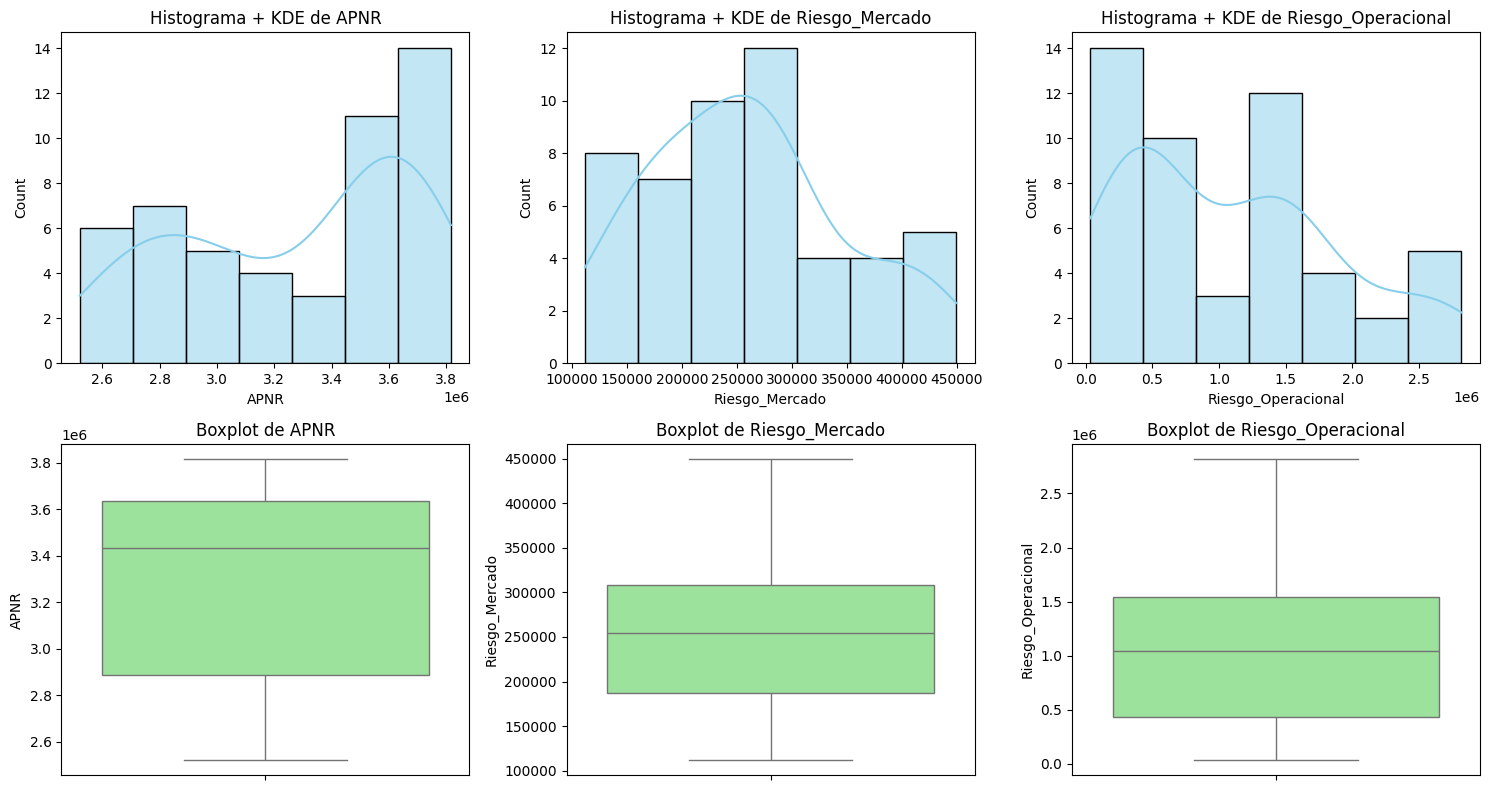

In [17]:
# Variables principales
vars_riesgo = ["APNR", "Riesgo_Mercado", "Riesgo_Operacional"]

# Crear figura con 2 filas (histogramas + boxplots)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Histogramas con KDE
for i, var in enumerate(vars_riesgo):
    sns.histplot(df_pivot[var], kde=True, ax=axes[0, i], color="skyblue")
    axes[0, i].set_title(f"Histograma + KDE de {var}")

# Boxplots comparativos
for i, var in enumerate(vars_riesgo):
    sns.boxplot(y=df_pivot[var], ax=axes[1, i], color="lightgreen")
    axes[1, i].set_title(f"Boxplot de {var}")

plt.tight_layout()
plt.show()

In [26]:
# Variables a analizar
variables = ['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']
for var in variables:
    data = df_pivot[var].dropna()
    
    print(f"\n--- Estadísticas descriptivas para {var} ---")
    print(data.describe())
    print(f"Máximo: {data.max()}, Mínimo: {data.min()}")


--- Estadísticas descriptivas para APNR ---
count        50.00
mean    3277885.05
std      408736.58
min     2521529.48
25%     2887730.41
50%     3435859.08
75%     3636370.52
max     3816362.54
Name: APNR, dtype: float64
Máximo: 3816362.544, Mínimo: 2521529.484

--- Estadísticas descriptivas para Riesgo_Mercado ---
count       50.00
mean    258445.91
std      88068.79
min     111843.62
25%     187083.28
50%     254826.01
75%     308568.31
max     449466.59
Name: Riesgo_Mercado, dtype: float64
Máximo: 449466.595, Mínimo: 111843.615

--- Estadísticas descriptivas para Riesgo_Operacional ---
count        50.00
mean    1089435.44
std      804091.71
min       34038.79
25%      428403.40
50%     1040713.05
75%     1543455.12
max     2817633.20
Name: Riesgo_Operacional, dtype: float64
Máximo: 2817633.202, Mínimo: 34038.791


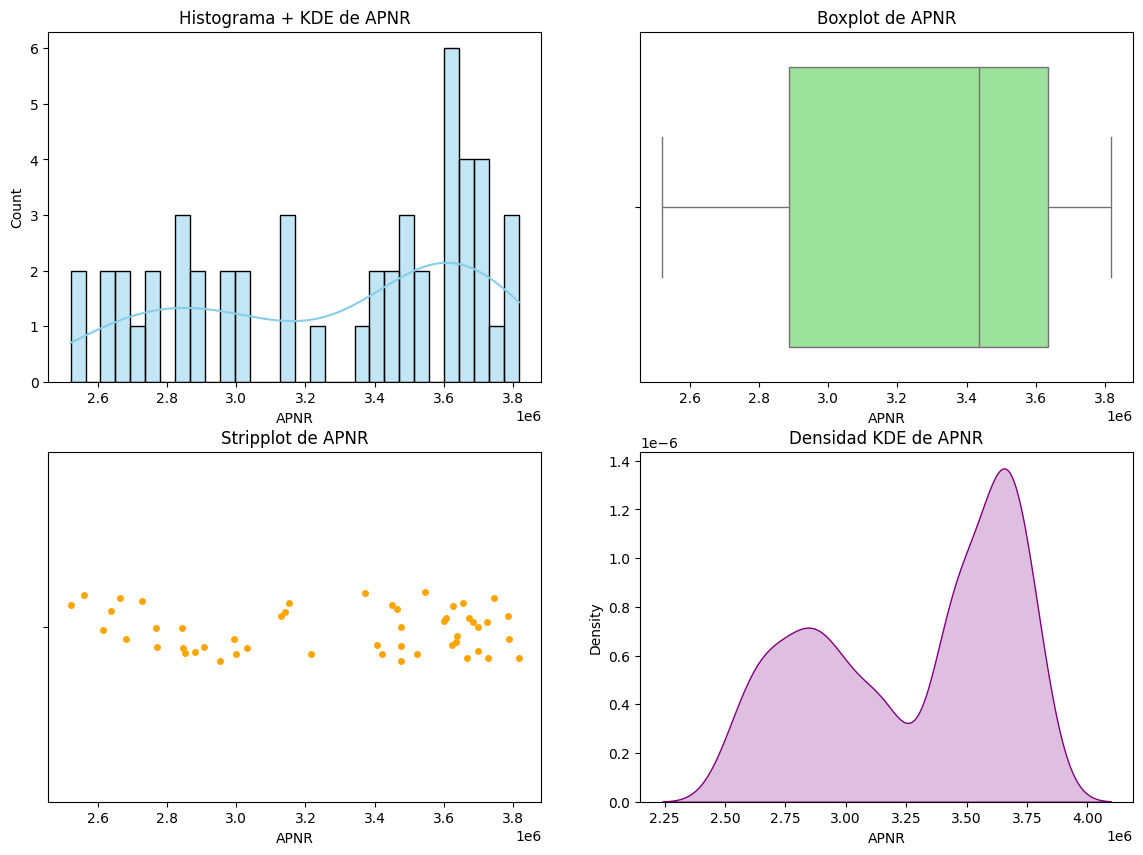

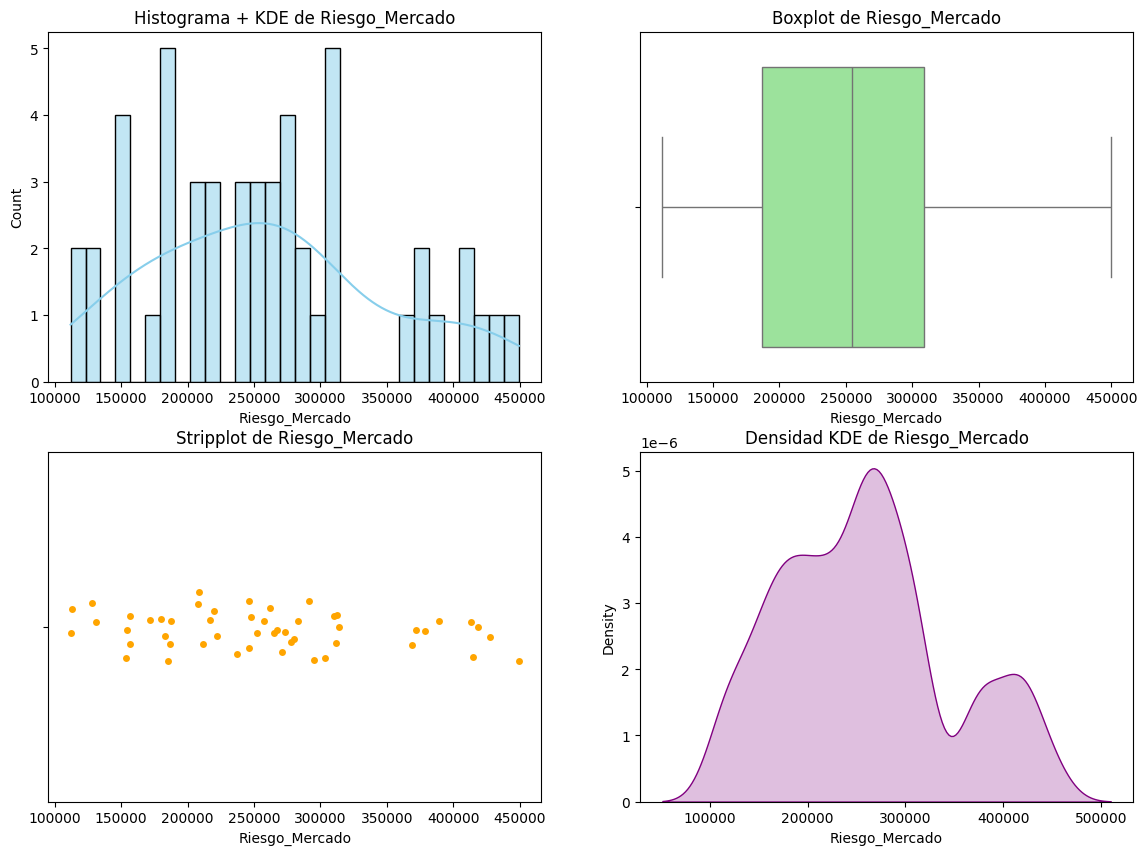

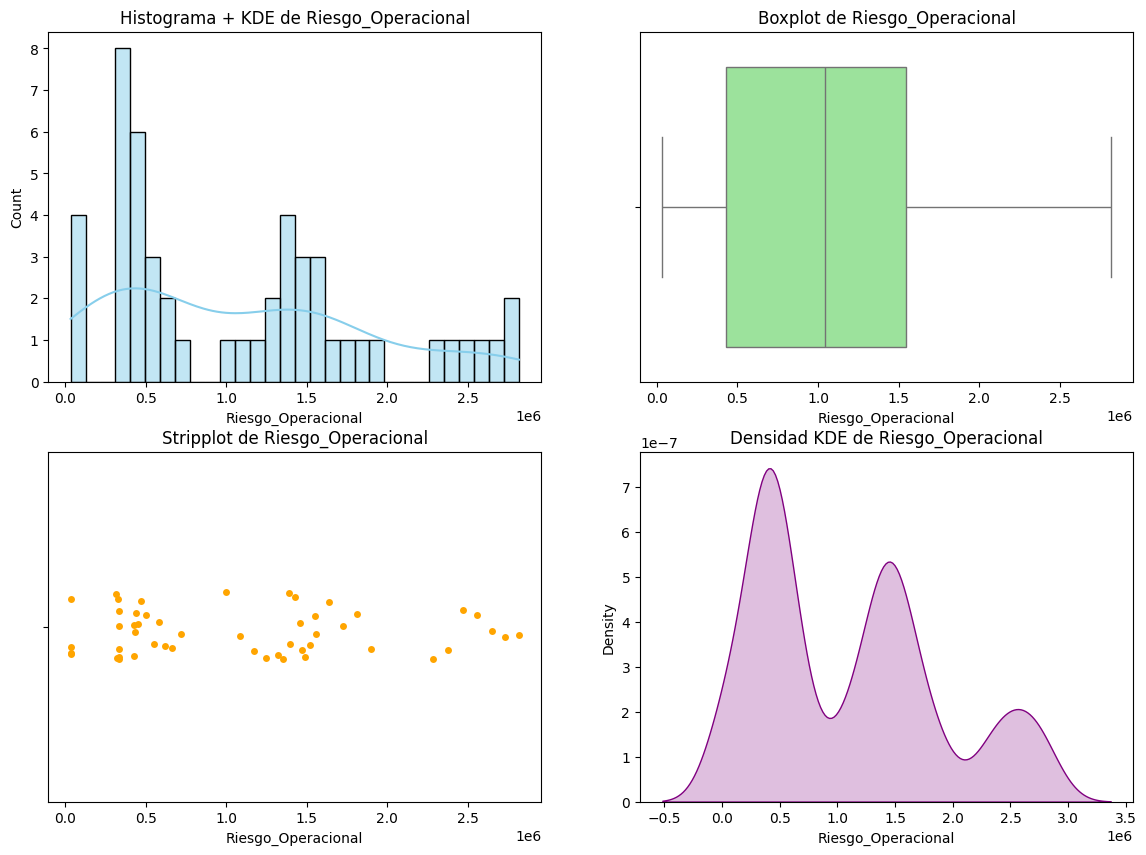

In [27]:
for var in variables:
    data = df_pivot[var].dropna()

    plt.figure(figsize=(14,10))

    # 1. Histograma + KDE
    plt.subplot(2,2,1)
    sns.histplot(data, kde=True, bins=30, color='skyblue')
    plt.title(f"Histograma + KDE de {var}")

    # 2. Boxplot
    plt.subplot(2,2,2)
    sns.boxplot(x=data, color='lightgreen')
    plt.title(f"Boxplot de {var}")

    # 3. Stripplot
    plt.subplot(2,2,3)
    sns.stripplot(x=data, color='orange', jitter=True)
    plt.title(f"Stripplot de {var}")

    # 4. Densidad KDE
    plt.subplot(2,2,4)
    sns.kdeplot(data, fill=True, color='purple', bw_adjust=0.5)
    plt.title(f"Densidad KDE de {var}")


# Analisis de correlación

<Axes: xlabel='Concepto', ylabel='Concepto'>

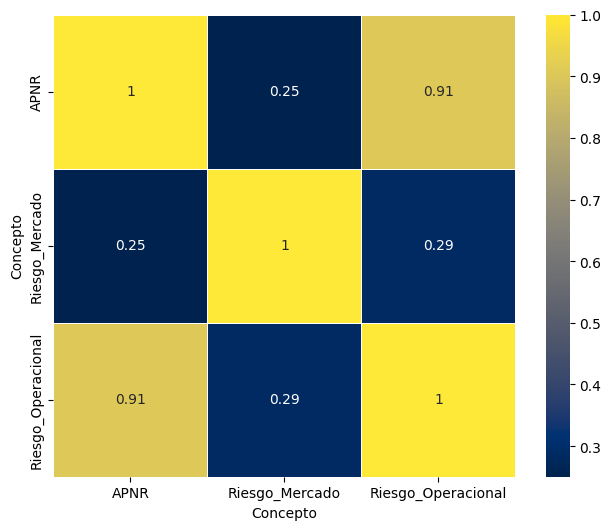

In [19]:
# Seleccionar las columnas de interés
df_variables = df_pivot[['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']]

corr = df_variables.corr()
# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(corr, 
             xticklabels=corr.columns.values,
             yticklabels=corr.columns.values,
             annot=True,
             cmap='cividis',  # Puedes elegir el colormap que prefieras
             square=True,
             linewidths=0.5)

In [20]:
# Resetear índice y renombrar columna índice como 'Concepto'
tabla_corr = corr.reset_index().rename(columns={'index': 'Concepto'})

# Mostrar tabla limpia lista para copiar a Word
print(tabla_corr.to_string(index=False))

          Concepto  APNR  Riesgo_Mercado  Riesgo_Operacional
              APNR  1.00            0.25                0.91
    Riesgo_Mercado  0.25            1.00                0.29
Riesgo_Operacional  0.91            0.29                1.00


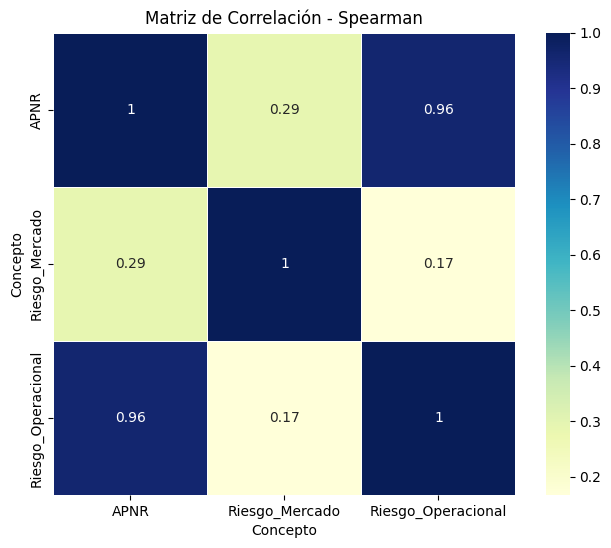

In [21]:
# ------------------------
# Correlación de Spearman
# ------------------------
corr_spearman = df_variables.corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_spearman,
            xticklabels=corr_spearman.columns.values,
            yticklabels=corr_spearman.columns.values,
            annot=True,
            cmap='YlGnBu',
            square=True,
            linewidths=0.5)
plt.title('Matriz de Correlación - Spearman')
plt.show()

In [22]:
# Resetear índice y renombrar columna índice como 'Concepto'
tabla_corr_spearman = corr_spearman.reset_index().rename(columns={'index': 'Concepto'})

# Mostrar tabla limpia lista para copiar a Word
print(tabla_corr_spearman.to_string(index=False))

          Concepto  APNR  Riesgo_Mercado  Riesgo_Operacional
              APNR  1.00            0.29                0.96
    Riesgo_Mercado  0.29            1.00                0.17
Riesgo_Operacional  0.96            0.17                1.00


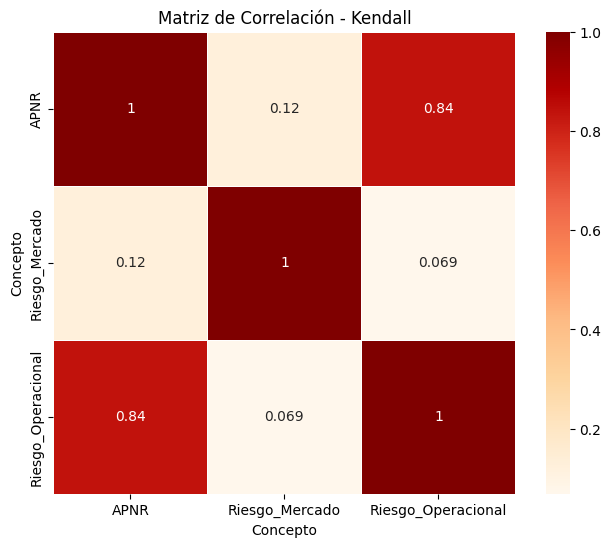

In [24]:
# ------------------------
# Correlación de Kendall
# ------------------------
corr_kendall = df_variables.corr(method='kendall')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_kendall,
            xticklabels=corr_kendall.columns.values,
            yticklabels=corr_kendall.columns.values,
            annot=True,
            cmap='OrRd',
            square=True,
            linewidths=0.5)
plt.title('Matriz de Correlación - Kendall')
plt.show()

In [25]:
# Resetear índice y renombrar columna índice como 'Concepto'
tabla_corr_kendall = corr_kendall.reset_index().rename(columns={'index': 'Concepto'})

# Mostrar tabla limpia lista para copiar a Word
print(tabla_corr_kendall.to_string(index=False))

          Concepto  APNR  Riesgo_Mercado  Riesgo_Operacional
              APNR  1.00            0.12                0.84
    Riesgo_Mercado  0.12            1.00                0.07
Riesgo_Operacional  0.84            0.07                1.00


# Con distribuciones ajustadas a los datos

Riesgo de crédito

[21-08-2025 20:49:37] [distfit.distfit] fit
[21-08-2025 20:49:37] [distfit.distfit] transform
[21-08-2025 20:49:37] [distfit.distfit] [norm      ] [0.0 sec] [RSS: 2.06087e-12] [loc=3277885.048 scale=404628.569]
[21-08-2025 20:49:37] [distfit.distfit] [expon     ] [0.0 sec] [RSS: 2.61973e-12] [loc=2521529.484 scale=756355.564]
[21-08-2025 20:49:37] [distfit.distfit] [pareto    ] [0.00 sec] [RSS: 4.98805e-12] [loc=2521529.484 scale=0.000]
[21-08-2025 20:49:37] [distfit.distfit] [dweibull  ] [0.02 sec] [RSS: 8.46009e-13] [loc=3256747.494 scale=418144.297]
[21-08-2025 20:49:37] [distfit.distfit] [t         ] [0.05 sec] [RSS: 4.52889e-12] [loc=-4819.222 scale=3305211.855]
[21-08-2025 20:49:37] [distfit.distfit] [genextreme] [0.03 sec] [RSS: 8.77542e-13] [loc=3243095.277 scale=472081.958]
[21-08-2025 20:49:37] [distfit.distfit] [gamma     ] [0.01 sec] [RSS: 2.08917e-12] [loc=-3455168.917 scale=25128.807]
[21-08-2025 20:49:37] [distfit.distfit] [lognorm   ] [0.0 sec] [RSS: 2.0609e-12] [loc=-1

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'Beta (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

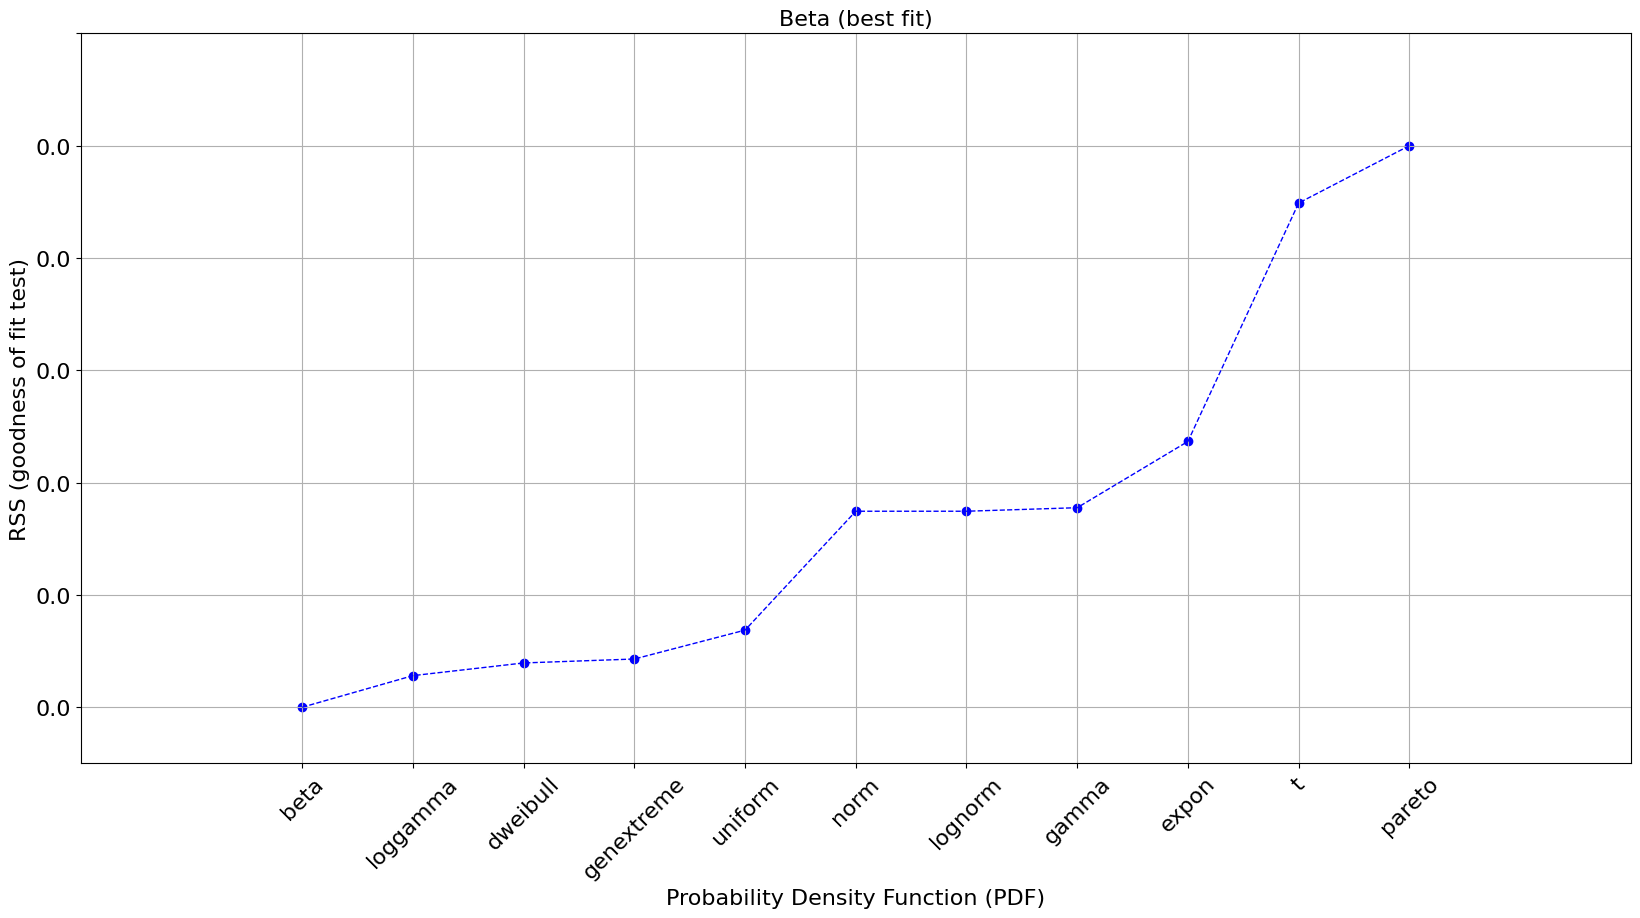

In [24]:
# Initialize
dist = distfit()

# Search for best theoretical fit on your emperical data
dist.fit_transform(df_variables['APNR'])

summary_rc = dist.summary

# summay plot
dist.plot_summary()

In [25]:
generate_rc = dist.generate(n=10000)
generate_rc

[21-08-2025 20:49:37] [distfit.distfit] Create Synthetic data for 10000 beta distributed samples with fitted params (np.float64(0.6335408045102662), np.float64(0.4222923665306137), np.float64(2518377.7585722106), np.float64(1297984.78542779)).


array([3799523.36236406, 3806649.31468627, 3809510.55764342, ...,
       3731863.17408538, 3471558.25416614, 3772282.13013998],
      shape=(10000,))

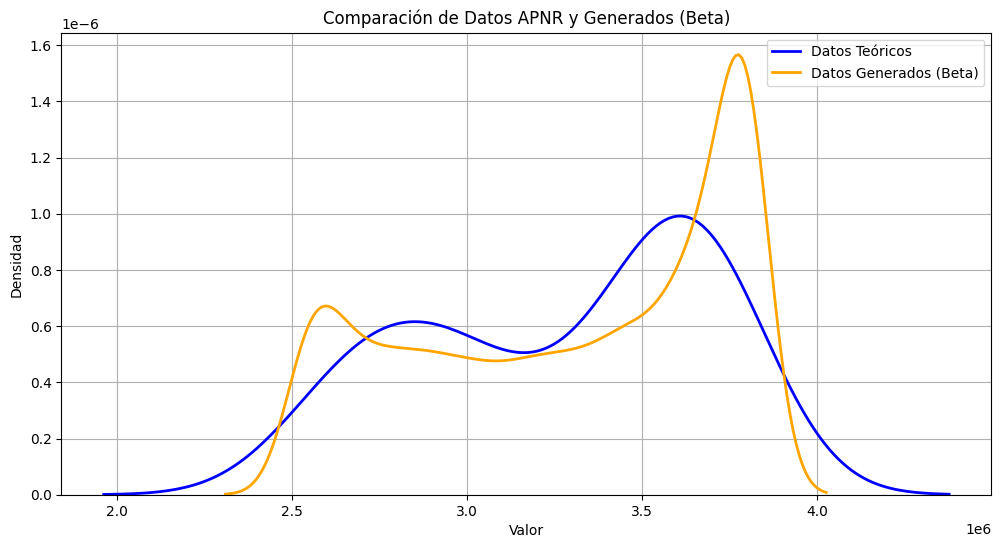

In [26]:
# Definir tus datos teóricos
data_teorica = df_variables['APNR']  # Asegúrate de que estos datos estén disponibles

# Visualizar la comparación
plt.figure(figsize=(12, 6))

# Estimación de densidad de kernel para datos teóricos
sns.kdeplot(data_teorica, color='blue', label='Datos Teóricos', fill=False, lw=2)

# Estimación de densidad de kernel para los datos generados
sns.kdeplot(generate_rc, color='orange', label='Datos Generados (Beta)', fill=False, lw=2)

plt.title('Comparación de Datos APNR y Generados (Beta)')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.grid()
plt.show()

Riesgo de mercado

[21-08-2025 20:49:37] [distfit.distfit] fit
[21-08-2025 20:49:37] [distfit.distfit] transform
[21-08-2025 20:49:38] [distfit.distfit] [norm      ] [0.00 sec] [RSS: 7.54918e-12] [loc=258445.914 scale=87183.658]
[21-08-2025 20:49:38] [distfit.distfit] [expon     ] [0.0 sec] [RSS: 1.88763e-11] [loc=111843.615 scale=146602.299]
[21-08-2025 20:49:38] [distfit.distfit] [pareto    ] [0.0 sec] [RSS: 6.60271e-11] [loc=111843.615 scale=0.000]
[21-08-2025 20:49:38] [distfit.distfit] [dweibull  ] [0.0 sec] [RSS: 8.01928e-12] [loc=254765.661 scale=74760.540]
[21-08-2025 20:49:38] [distfit.distfit] [t         ] [0.06 sec] [RSS: 7.54918e-12] [loc=258445.913 scale=87183.654]
[21-08-2025 20:49:38] [distfit.distfit] [genextreme] [0.06 sec] [RSS: 5.99162e-11] [loc=111844.336 scale=5.494]
[21-08-2025 20:49:38] [distfit.distfit] [gamma     ] [0.00 sec] [RSS: 7.24641e-12] [loc=28325.427 scale=34750.848]
[21-08-2025 20:49:38] [distfit.distfit] [lognorm   ] [0.0 sec] [RSS: 7.22749e-12] [loc=-123323.770 scale=

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'Beta (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

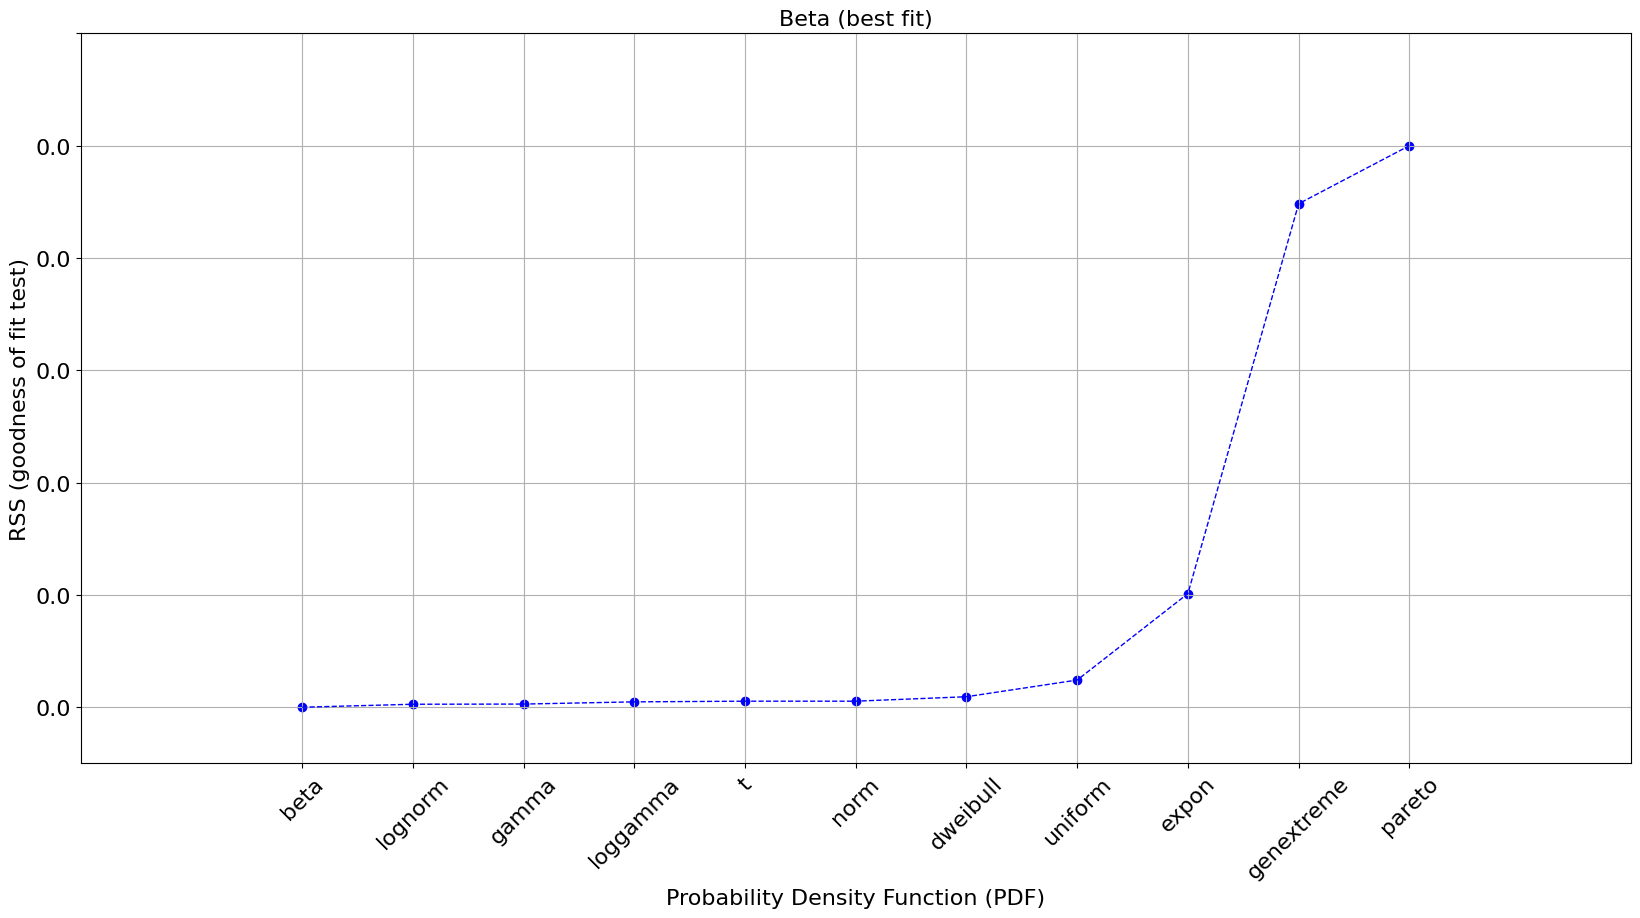

In [27]:
# Initialize
dist = distfit()

# Search for best theoretical fit on your emperical data
dist.fit_transform(df_variables['Riesgo_Mercado'])

summary_rm=dist.summary

# summay plot
dist.plot_summary()

In [28]:
generate_rm = dist.generate(n=10000)
generate_rm

[21-08-2025 20:49:38] [distfit.distfit] Create Synthetic data for 10000 beta distributed samples with fitted params (np.float64(0.9759154024825465), np.float64(1.2513278783700863), np.float64(111843.61499999999), np.float64(338308.20330357295)).


array([299872.37767025, 358129.58534663, 336918.10808798, ...,
       409770.47744814, 208631.79283917, 121084.00162737], shape=(10000,))

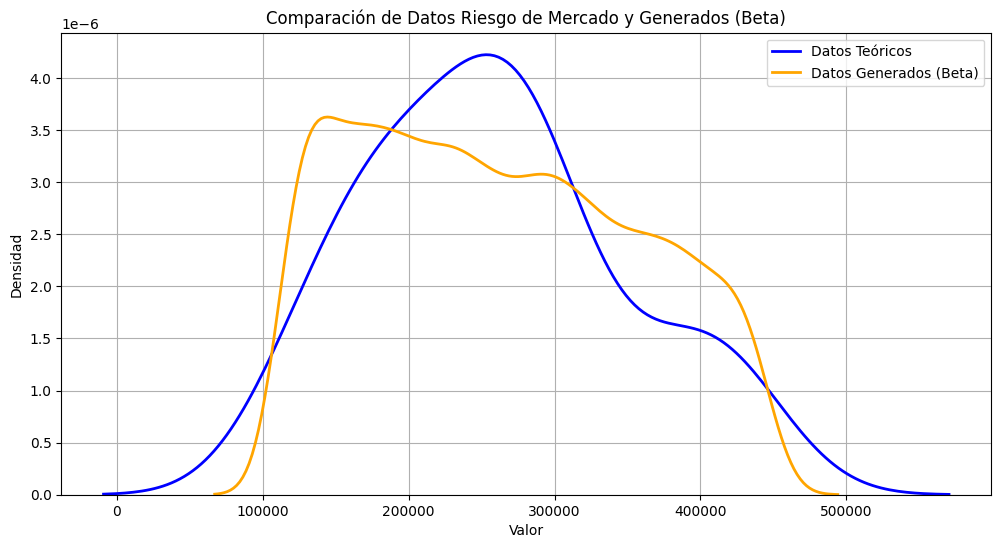

In [29]:
# Definir tus datos teóricos
data_teorica = df_variables['Riesgo_Mercado']  # Asegúrate de que estos datos estén disponibles

# Visualizar la comparación
plt.figure(figsize=(12, 6))

# Estimación de densidad de kernel para datos teóricos
sns.kdeplot(data_teorica, color='blue', label='Datos Teóricos', fill=False, lw=2)

# Estimación de densidad de kernel para los datos generados
sns.kdeplot(generate_rm, color='orange', label='Datos Generados (Beta)', fill=False, lw=2)

plt.title('Comparación de Datos Riesgo de Mercado y Generados (Beta)')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.grid()
plt.show()

[21-08-2025 20:49:38] [distfit.distfit] fit
[21-08-2025 20:49:38] [distfit.distfit] transform
[21-08-2025 20:49:38] [distfit.distfit] [norm      ] [0.00 sec] [RSS: 7.54918e-12] [loc=258445.914 scale=87183.658]
[21-08-2025 20:49:38] [distfit.distfit] [expon     ] [0.00 sec] [RSS: 1.88763e-11] [loc=111843.615 scale=146602.299]
[21-08-2025 20:49:38] [distfit.distfit] [pareto    ] [0.00 sec] [RSS: 6.60271e-11] [loc=111843.615 scale=0.000]
[21-08-2025 20:49:38] [distfit.distfit] [dweibull  ] [0.0 sec] [RSS: 8.01928e-12] [loc=254765.661 scale=74760.540]
[21-08-2025 20:49:38] [distfit.distfit] [t         ] [0.05 sec] [RSS: 7.54918e-12] [loc=258445.913 scale=87183.654]
[21-08-2025 20:49:38] [distfit.distfit] [genextreme] [0.02 sec] [RSS: 5.99162e-11] [loc=111844.336 scale=5.494]
[21-08-2025 20:49:38] [distfit.distfit] [gamma     ] [0.02 sec] [RSS: 7.24641e-12] [loc=28325.427 scale=34750.848]
[21-08-2025 20:49:38] [distfit.distfit] [lognorm   ] [0.00 sec] [RSS: 7.22749e-12] [loc=-123323.770 sca

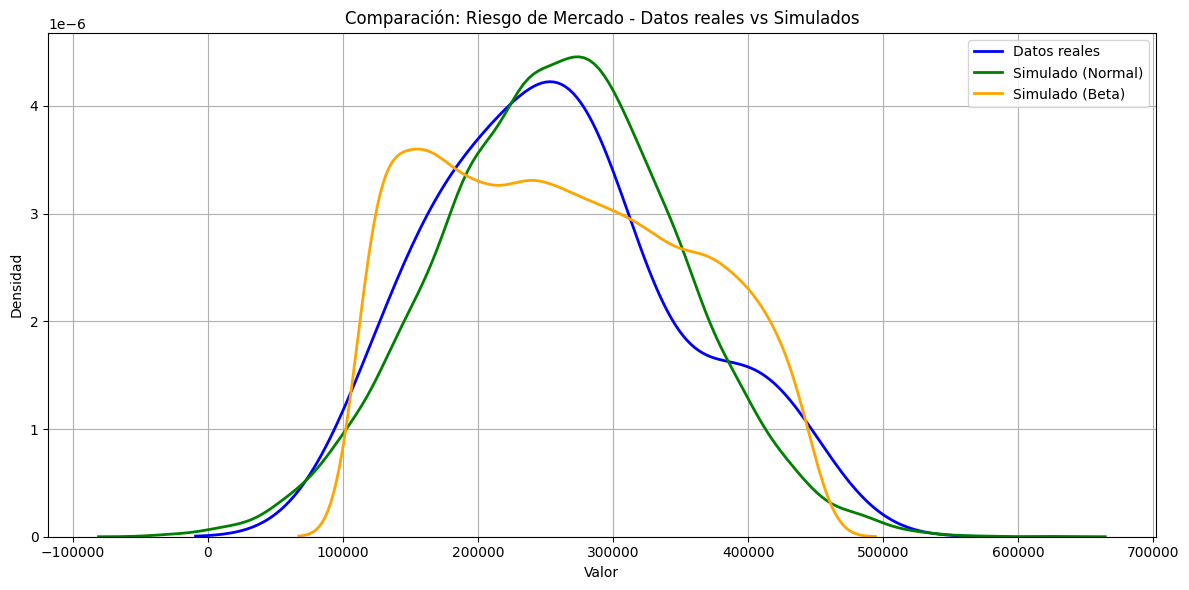

In [30]:
from distfit import distfit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta as beta_dist

# Datos reales limpios
data_real = df_variables['Riesgo_Mercado'].dropna()

# Ajustar distribuciones con distfit
dist = distfit()
dist.fit_transform(data_real)

# Obtener parámetros de la normal desde el resumen
mu = dist.summary.loc[dist.summary['name'] == 'norm', 'loc'].values[0]
sigma = dist.summary.loc[dist.summary['name'] == 'norm', 'scale'].values[0]

# Generar datos sintéticos normales
synthetic_normal_rm = np.random.normal(loc=mu, scale=sigma, size=10000)

# Obtener parámetros beta (a, b, loc, scale) del resumen
row_beta = dist.summary.loc[dist.summary['name'] == 'beta'].iloc[0]
a, b = row_beta['arg']
loc_beta = row_beta['loc']
scale_beta = row_beta['scale']

# Generar datos sintéticos beta con scipy.stats.beta
synthetic_beta = beta_dist.rvs(a, b, loc=loc_beta, scale=scale_beta, size=10000)

# Visualizar comparaciones
plt.figure(figsize=(12, 6))

sns.kdeplot(data_real, label='Datos reales', color='blue', lw=2)
sns.kdeplot(synthetic_normal_rm, label='Simulado (Normal)', color='green', lw=2)
sns.kdeplot(synthetic_beta, label='Simulado (Beta)', color='orange', lw=2)

plt.title('Comparación: Riesgo de Mercado - Datos reales vs Simulados')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
generate_rm=synthetic_normal_rm

In [32]:
from scipy.stats import ks_2samp

# Datos reales limpios
data_real = df_variables['Riesgo_Mercado'].dropna()

# Supongo que ya tienes generados los datos sintéticos con normal y beta:
# synthetic_normal
# synthetic_beta

# Test KS: real vs normal
ks_normal = ks_2samp(data_real, generate_rm)
print(f"KS test Normal: statistic={ks_normal.statistic:.4f}, p-value={ks_normal.pvalue:.4f}")

# Test KS: real vs beta
ks_beta = ks_2samp(data_real, synthetic_beta)
print(f"KS test Beta: statistic={ks_beta.statistic:.4f}, p-value={ks_beta.pvalue:.4f}")

KS test Normal: statistic=0.0872, p-value=0.8125
KS test Beta: statistic=0.1380, p-value=0.2739


Riesgo operacional

[21-08-2025 20:49:39] [distfit.distfit] fit
[21-08-2025 20:49:39] [distfit.distfit] transform
[21-08-2025 20:49:39] [distfit.distfit] [norm      ] [0.0 sec] [RSS: 3.80403e-13] [loc=1089435.442 scale=796010.183]
[21-08-2025 20:49:39] [distfit.distfit] [expon     ] [0.0 sec] [RSS: 2.07963e-13] [loc=34038.791 scale=1055396.651]
[21-08-2025 20:49:39] [distfit.distfit] [pareto    ] [0.0 sec] [RSS: 1.15216e-12] [loc=34038.791 scale=0.000]
[21-08-2025 20:49:39] [distfit.distfit] [dweibull  ] [0.01 sec] [RSS: 1.51214e-13] [loc=947552.904 scale=776504.323]
[21-08-2025 20:49:39] [distfit.distfit] [t         ] [0.04 sec] [RSS: 3.80402e-13] [loc=1089443.098 scale=796020.666]
[21-08-2025 20:49:39] [distfit.distfit] [genextreme] [0.02 sec] [RSS: 1.24827e-12] [loc=34039.004 scale=0.438]
[21-08-2025 20:49:39] [distfit.distfit] [gamma     ] [0.02 sec] [RSS: 2.62439e-13] [loc=34038.791 scale=1108057.948]
[21-08-2025 20:49:39] [distfit.distfit] [lognorm   ] [0.0 sec] [RSS: 2.71111e-13] [loc=-362269.588 s

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'Dweibull (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

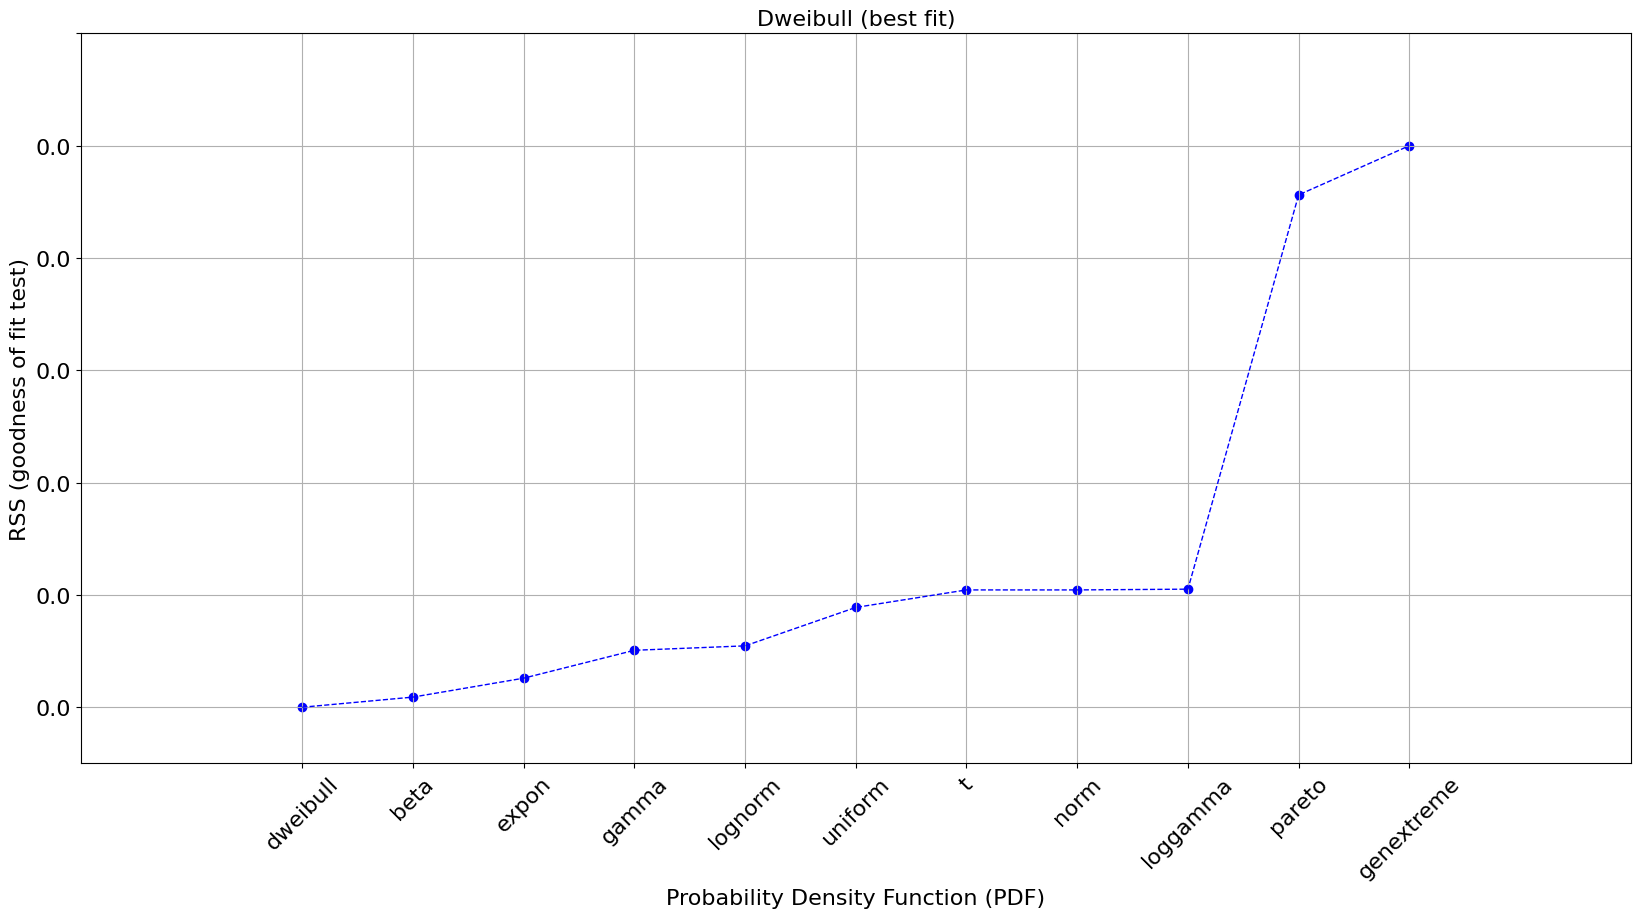

In [33]:
# Initialize
dist = distfit()

# Search for best theoretical fit on your emperical data
dist.fit_transform(df_variables['Riesgo_Operacional'])

summary_ro=dist.summary

# summay plot
dist.plot_summary()

In [34]:
generate_ro = dist.generate(n=10000)
generate_ro

[21-08-2025 20:49:39] [distfit.distfit] Create Synthetic data for 10000 dweibull distributed samples with fitted params (np.float64(1.7366716765665888), np.float64(947552.903681553), np.float64(776504.3229104585)).


array([2133116.42889992, 2677716.72102985, 1495899.25693316, ...,
       1422749.51275618,  816837.17900179, 1586902.15630759],
      shape=(10000,))

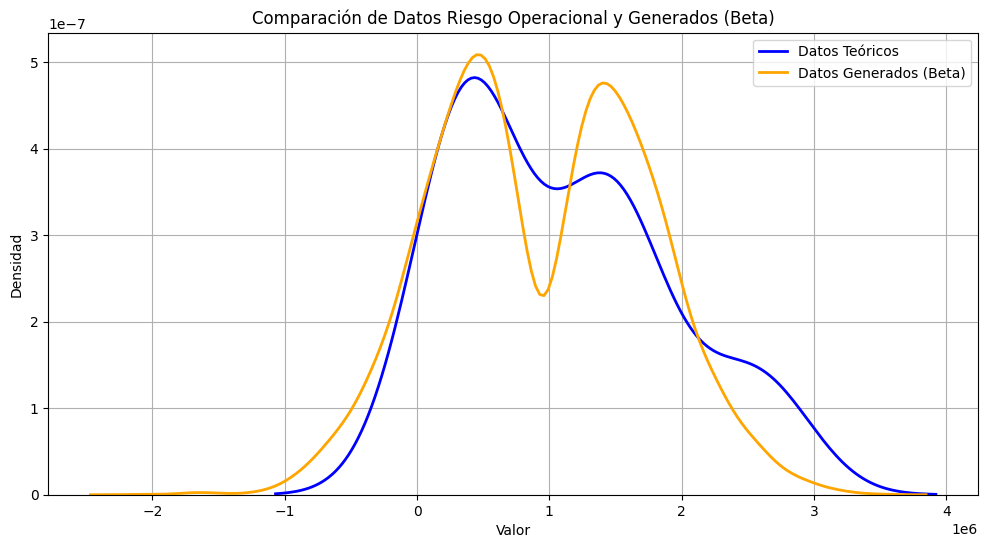

In [35]:
# Definir tus datos teóricos
data_teorica = df_variables['Riesgo_Operacional']  # Asegúrate de que estos datos estén disponibles

# Visualizar la comparación
plt.figure(figsize=(12, 6))

# Estimación de densidad de kernel para datos teóricos
sns.kdeplot(data_teorica, color='blue', label='Datos Teóricos', fill=False, lw=2)

# Estimación de densidad de kernel para los datos generados
sns.kdeplot(generate_ro, color='orange', label='Datos Generados (Beta)', fill=False, lw=2)

plt.title('Comparación de Datos Riesgo Operacional y Generados (Beta)')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.grid()
plt.show()

In [36]:
Total=generate_ro+generate_rc+generate_rm

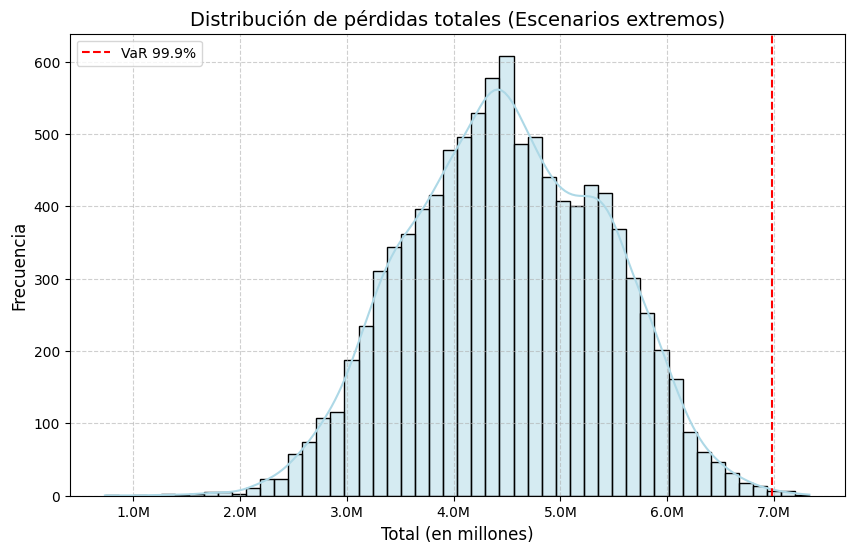

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Histograma de pérdidas totales
plt.figure(figsize=(10,6))
Tloss = sns.histplot(Total, color='lightblue', bins=50, kde=True, edgecolor='black')

# Línea del percentil 99.9%
VaR_999 = np.percentile(Total, 99.9)
plt.axvline(VaR_999, color='red', linestyle='--', label='VaR 99.9%')

# Títulos y etiquetas
plt.title('Distribución de pérdidas totales (Escenarios extremos)', fontsize=14)
plt.xlabel('Total (en millones)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Formatear eje X en millones
formatter = FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M')
plt.gca().xaxis.set_major_formatter(formatter)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [38]:
np.percentile(Total,99.9)

np.float64(6982130.431582589)

In [39]:
# Calcular estadísticos clave
percentiles = np.percentile(Total, [95, 99, 99.9])
media = np.mean(Total)
desv = np.std(Total)

# Crear tabla resumen
tabla_resultados = pd.DataFrame({
    "Estadístico": ["Media", "Desviación estándar", "Percentil 95", "Percentil 99", "Percentil 99.9"],
    "Valor": [media, desv, percentiles[0], percentiles[1], percentiles[2]]
})

print(tabla_resultados)

           Estadístico      Valor
0                Media 4498872.96
1  Desviación estándar  910830.32
2         Percentil 95 5958797.63
3         Percentil 99 6458720.13
4       Percentil 99.9 6982130.43


# Con simulación multivariada (VaR - CoV)

In [40]:
# Seleccionar las columnas de interés
df_variables = df_pivot[['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']]

In [41]:
# Calcular la covarianza y las medias
COV = df_variables.cov()
MRC = df_variables['APNR'].mean()
MRM = df_variables['Riesgo_Mercado'].mean()
MRO = df_variables['Riesgo_Operacional'].mean()

# Generar simulaciones multivariadas
simulacion_MV = multivariate_normal(
    mean=[MRC, MRM, MRO],
    cov=COV
).rvs(10000, random_state=1)

# Convertir a DataFrame
simulacion_MV = pd.DataFrame(simulacion_MV, columns=['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional'])

# Calcular total
simulacion_MV['Total'] = simulacion_MV['APNR'] + simulacion_MV['Riesgo_Mercado'] + simulacion_MV['Riesgo_Operacional']

# Calcular percentil, por ejemplo, al 95%
percentil_99 = np.percentile(simulacion_MV['Total'], 99)

print(f"VaR al 99%: {percentil_99}")

VaR al 99%: 7436022.046688227


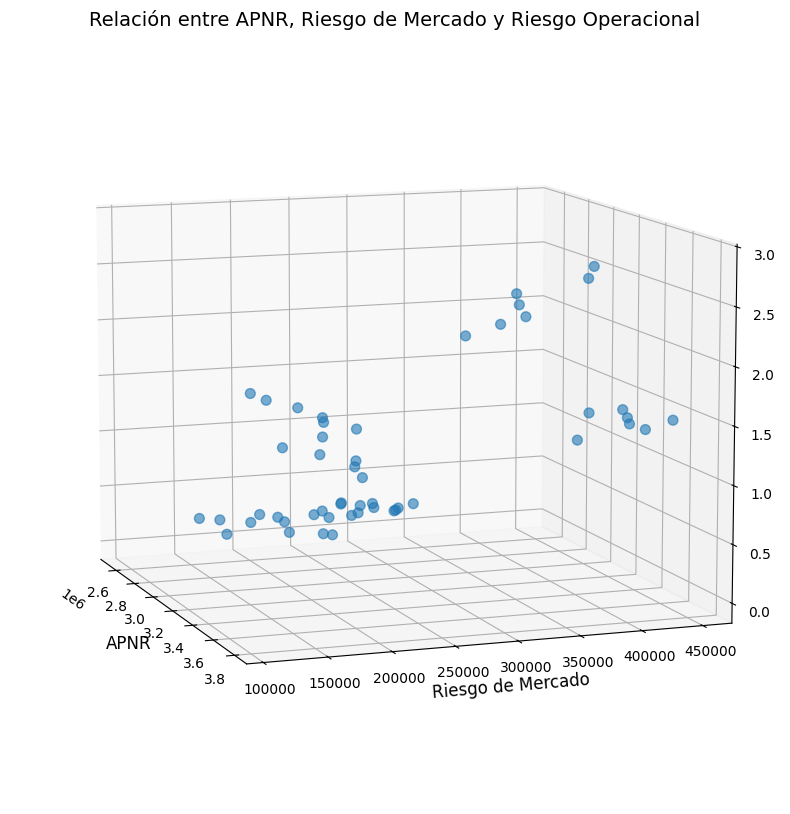

In [42]:
# Generar datos de ejemplo
x_real = df_variables['APNR']
y_real = df_variables['Riesgo_Mercado']
z_real = df_variables['Riesgo_Operacional']

# Crear la figura y el eje 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

# Graficar los puntos
ax.scatter(x_real, y_real, z_real, s=50, alpha=0.6)

# Configurar el título y las etiquetas de los ejes
ax.set_title('Relación entre APNR, Riesgo de Mercado y Riesgo Operacional', fontsize=14)
ax.set_xlabel('APNR', fontsize=12)
ax.set_ylabel('Riesgo de Mercado', fontsize=12)

# Ajustar la etiqueta del eje Z para que sea visible
ax.set_zlabel('Riesgo Operacional', fontsize=12, labelpad=15)

# -------------------------------------------------------------------
# La solución principal está aquí: ajustar el ángulo de visión
# -------------------------------------------------------------------
# `elev` (elevación) eleva o baja la vista.
# `azim` (azimut) rota la vista horizontalmente.
# Cambié el valor de azimut para mostrar el eje Z de frente.
ax.view_init(elev=10, azim= -20) # Prueba diferentes valores

# Mostrar el gráfico
plt.show()

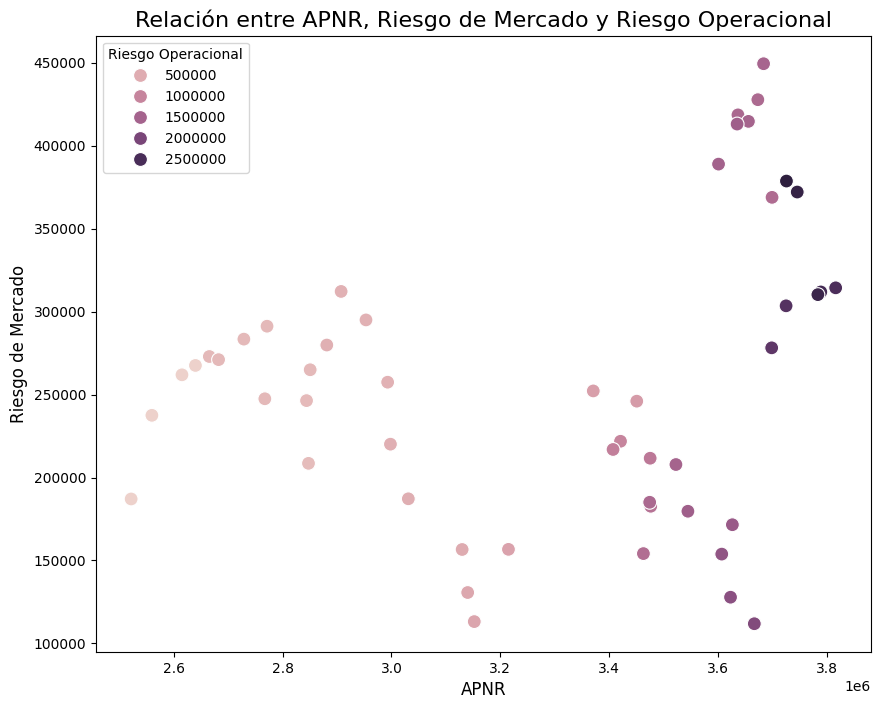

In [43]:
# Crear el gráfico de dispersión con Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_variables, x='APNR', y='Riesgo_Mercado', hue='Riesgo_Operacional', s=100)

# Añadir título y etiquetas
plt.title('Relación entre APNR, Riesgo de Mercado y Riesgo Operacional', fontsize=16)
plt.xlabel('APNR', fontsize=12)
plt.ylabel('Riesgo de Mercado', fontsize=12)
plt.legend(title='Riesgo Operacional')

plt.show()

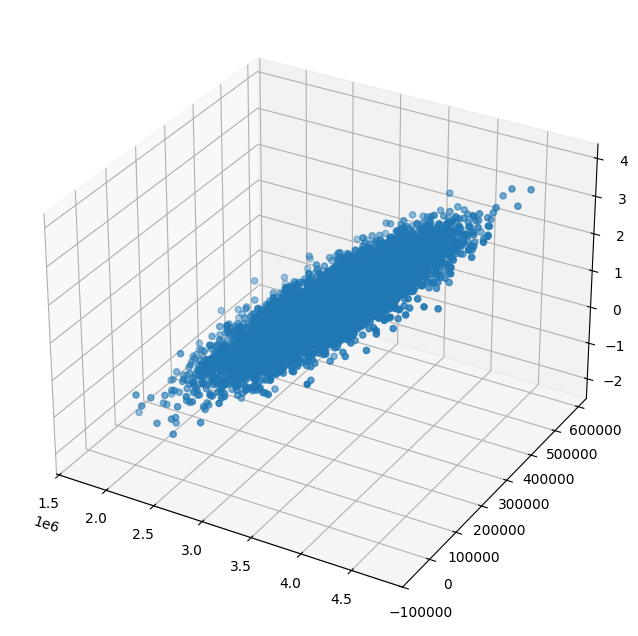

In [44]:
# Generar datos de ejemplo
x_simulado = simulacion_MV['APNR']
y_simulado = simulacion_MV['Riesgo_Mercado']
z_simulado = simulacion_MV['Riesgo_Operacional']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_simulado, y_simulado, z_simulado)

plt.show()

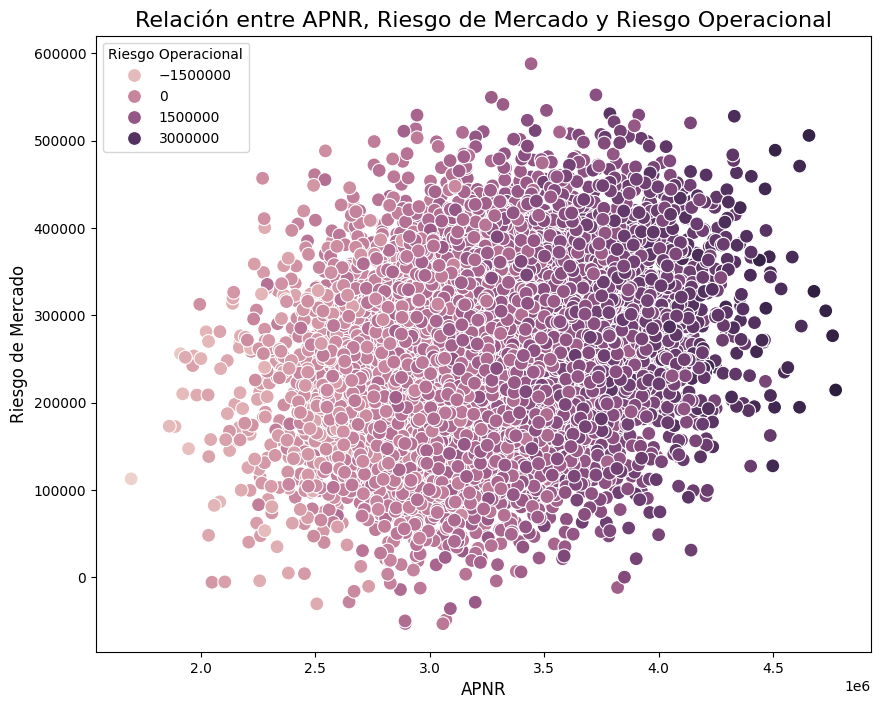

In [45]:
# Crear el gráfico de dispersión con Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=simulacion_MV, x='APNR', y='Riesgo_Mercado', hue='Riesgo_Operacional', s=100)

# Añadir título y etiquetas
plt.title('Relación entre APNR, Riesgo de Mercado y Riesgo Operacional', fontsize=16)
plt.xlabel('APNR', fontsize=12)
plt.ylabel('Riesgo de Mercado', fontsize=12)
plt.legend(title='Riesgo Operacional')

plt.show()

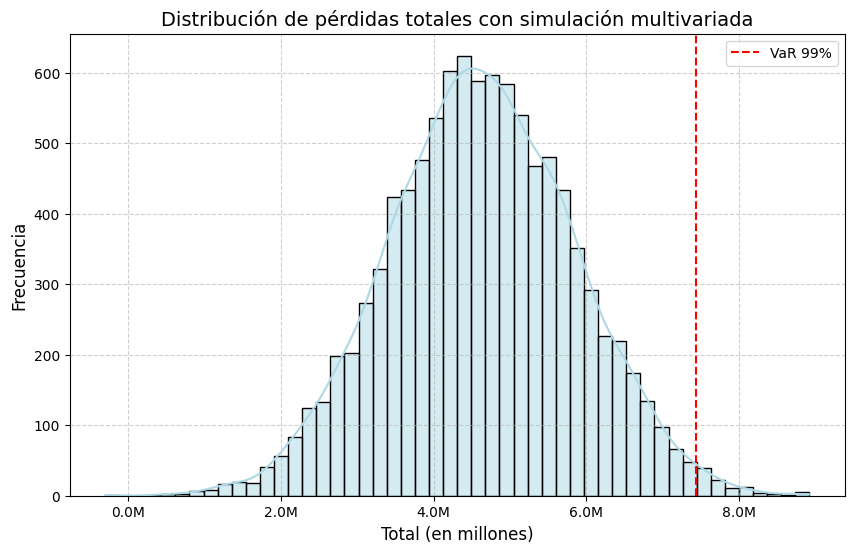

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Histograma de pérdidas totales
plt.figure(figsize=(10,6))
sns.histplot(simulacion_MV['Total'], bins=50, kde=True, color='lightblue', edgecolor='black')

# Línea del VaR al 99%
plt.axvline(percentil_99, color='red', linestyle='--', label='VaR 99%')

# Etiquetas
plt.title('Distribución de pérdidas totales con simulación multivariada', fontsize=14)
plt.xlabel('Total (en millones)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Formatear eje X en millones
formatter = FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M')
plt.gca().xaxis.set_major_formatter(formatter)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [47]:
# Calcular estadísticos clave
percentiles = np.percentile(simulacion_MV['Total'], [95, 99, 99.9])
media = np.mean(simulacion_MV['Total'])
desv = np.std(simulacion_MV['Total'])

# Crear tabla resumen
tabla_resultados = pd.DataFrame({
    "Estadístico": ["Media", "Desviación estándar", "Percentil 95", "Percentil 99", "Percentil 99.9"],
    "Valor": [media, desv, percentiles[0], percentiles[1], percentiles[2]]
})

print(tabla_resultados)

           Estadístico      Valor
0                Media 4626737.10
1  Desviación estándar 1215699.17
2         Percentil 95 6642481.94
3         Percentil 99 7436022.05
4       Percentil 99.9 8314205.71


# Copulas

In [48]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pyvinecopulib as pv
from copulae import StudentCopula, GaussianCopula

In [49]:
# Tus datos reales ya seleccionados
df_variables = df_pivot[['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']]

In [50]:
import numpy as np
import pandas as pd
import pyvinecopulib as pv

# Supongo que df_variables ya está definido y contiene ['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']
# Ejemplo: df_variables = df_pivot[['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']]

# Transformar los datos originales a pseudo-observaciones uniformes [0,1]
u = pv.to_pseudo_obs(df_variables.values)

def fit_and_simulate(u, original_x, family_set, n_samples=10000):
    # Configurar control de ajuste con las familias especificadas
    controls = pv.FitControlsVinecop(family_set=family_set)
    
    # Ajustar el modelo vine copula a los datos uniformes
    vine = pv.Vinecop.from_data(u, controls=controls)
    
    print(f"\nModelo ajustado con familias: {[f.name for f in family_set]}")
    print(vine)
    
    # Simular n_samples datos del modelo ajustado
    u_sim = vine.simulate(n_samples, seeds=[1, 2, 3, 4])
    
    # Reescalar simulaciones a la escala original usando cuantiles empíricos
    x_sim = np.array([np.quantile(original_x[:, i], u_sim[:, i]) for i in range(original_x.shape[1])]).T
    
    # Calcular log-verosimilitud, AIC y BIC sobre los datos originales uniformes
    log_lik = vine.loglik(u)
    aic = vine.aic(u)
    bic = vine.bic(u)
    
    return vine, x_sim, log_lik, aic, bic

# Ajustar y simular los tres modelos
vine_default, sim_default, ll_default, aic_default, bic_default = fit_and_simulate(
    u, df_variables.values, family_set=list(pv.BicopFamily))

vine_gauss, sim_gauss, ll_gauss, aic_gauss, bic_gauss = fit_and_simulate(
    u, df_variables.values, family_set=[pv.BicopFamily.gaussian])

vine_t, sim_t, ll_t, aic_t, bic_t = fit_and_simulate(
    u, df_variables.values, family_set=[pv.BicopFamily.student])

# Función para imprimir estadísticas de simulaciones
def print_stats(name, sim_data):
    print(f"\n{name} - Media simulada:\n{np.mean(sim_data, axis=0)}")
    print(f"{name} - Covarianza simulada:\n{np.cov(sim_data.T)}")

# Imprimir estadísticas originales
print("Media original:\n", np.mean(df_variables.values, axis=0))
print("Covarianza original:\n", np.cov(df_variables.values.T))

# Imprimir estadísticas simuladas
print_stats("Vine Copula default", sim_default)
print_stats("Vine Copula Gaussian", sim_gauss)
print_stats("Vine Copula t-Student", sim_t)

# Comparar log-verosimilitud y criterios AIC y BIC
print("\nComparación de modelos:")
print(f"Default vine: LogLik={ll_default:.2f}, AIC={aic_default:.2f}, BIC={bic_default:.2f}")
print(f"Gaussian vine: LogLik={ll_gauss:.2f}, AIC={aic_gauss:.2f}, BIC={bic_gauss:.2f}")
print(f"t-Student vine: LogLik={ll_t:.2f}, AIC={aic_t:.2f}, BIC={bic_t:.2f}")



Modelo ajustado con familias: ['indep', 'gaussian', 'student', 'clayton', 'gumbel', 'frank', 'joe', 'bb1', 'bb6', 'bb7', 'bb8', 'tawn', 'tll']
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types   family rotation   parameters  df   tau 
   1    1                  2, 1                             c, c      TLL          [30x30 grid] 9.5  0.16 
   1    2                  1, 3                             c, c    Frank        0        21.30 1.0  0.83 
   2    1                  2, 3                      1      c, c Gaussian        0        -0.41 1.0 -0.27 


Modelo ajustado con familias: ['gaussian']
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types   family rotation parameters  df   tau 
   1    1                  2, 1                             c, c Gaussian        0       0.32 1.0  0.21 
   1    2                  1, 3                             c, 

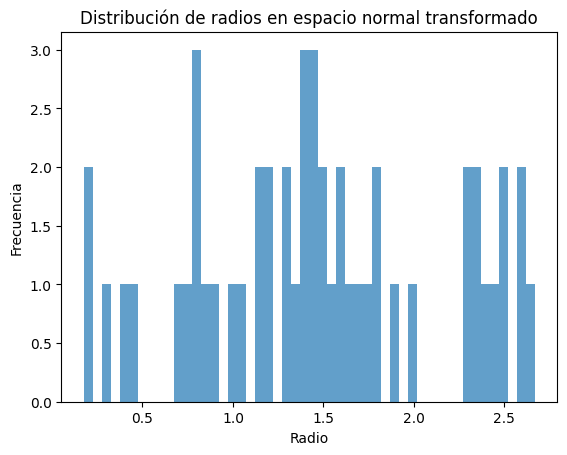

Prueba KS para simetría radial, p-valor: 1.0000
No se rechaza la hipótesis de simetría radial: datos compatibles con cópulas simétricas (e.g. Gaussiana, t-Student).

Modelo ajustado con familias: ['indep', 'gaussian', 'student', 'clayton', 'gumbel', 'frank', 'joe', 'bb1', 'bb6', 'bb7', 'bb8', 'tawn', 'tll']
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types   family rotation   parameters  df   tau 
   1    1                  2, 1                             c, c      TLL          [30x30 grid] 9.5  0.16 
   1    2                  1, 3                             c, c    Frank        0        21.30 1.0  0.83 
   2    1                  2, 3                      1      c, c Gaussian        0        -0.41 1.0 -0.27 


Modelo ajustado con familias: ['gaussian']
<pyvinecopulib.Vinecop> Vinecop model with 3 variables
tree edge conditioned variables conditioning variables var_types   family rotation parameters  df   tau 
   

In [53]:
import numpy as np
import pandas as pd
import pyvinecopulib as pv
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Supongo que df_variables ya está definido y contiene ['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']
# Ejemplo: df_variables = df_pivot[['APNR', 'Riesgo_Mercado', 'Riesgo_Operacional']]

# Transformar los datos originales a pseudo-observaciones uniformes [0,1]
u = pv.to_pseudo_obs(df_variables.values)

# --- Cálculo y test de simetría radial ---
# Transformar las pseudo-observaciones a espacio normal (inversa de la normal)
z = stats.norm.ppf(u)

# Calcular radios (norma euclidiana) de cada punto
radii = np.linalg.norm(z, axis=1)

# Histograma para visualización
plt.hist(radii, bins=50, alpha=0.7)
plt.title("Distribución de radios en espacio normal transformado")
plt.xlabel("Radio")
plt.ylabel("Frecuencia")
plt.show()

# Test de simetría radial: comparar radios con sus reflejos
stat, p_value = ks_2samp(radii, np.linalg.norm(-z, axis=1))
print(f"Prueba KS para simetría radial, p-valor: {p_value:.4f}")

if p_value > 0.05:
    print("No se rechaza la hipótesis de simetría radial: datos compatibles con cópulas simétricas (e.g. Gaussiana, t-Student).")
else:
    print("Se rechaza la hipótesis de simetría radial: considerar cópulas asimétricas o Vine con familias variadas.")

# --- Función para ajustar y simular modelos vine copula ---
def fit_and_simulate(u, original_x, family_set, n_samples=10000):
    controls = pv.FitControlsVinecop(family_set=family_set)
    vine = pv.Vinecop.from_data(u, controls=controls)
    print(f"\nModelo ajustado con familias: {[f.name for f in family_set]}")
    print(vine)
    u_sim = vine.simulate(n_samples, seeds=[1, 2, 3, 4])
    x_sim = np.array([np.quantile(original_x[:, i], u_sim[:, i]) for i in range(original_x.shape[1])]).T
    log_lik = vine.loglik(u)
    aic = vine.aic(u)
    bic = vine.bic(u)
    return vine, x_sim, log_lik, aic, bic

# Ajustar y simular los tres modelos
vine_default, sim_default, ll_default, aic_default, bic_default = fit_and_simulate(
    u, df_variables.values, family_set=list(pv.BicopFamily))

vine_gauss, sim_gauss, ll_gauss, aic_gauss, bic_gauss = fit_and_simulate(
    u, df_variables.values, family_set=[pv.BicopFamily.gaussian])

vine_t, sim_t, ll_t, aic_t, bic_t = fit_and_simulate(
    u, df_variables.values, family_set=[pv.BicopFamily.student])

# Función para imprimir estadísticas de simulaciones
def print_stats(name, sim_data):
    print(f"\n{name} - Media simulada:\n{np.mean(sim_data, axis=0)}")
    print(f"{name} - Covarianza simulada:\n{np.cov(sim_data.T)}")

# Imprimir estadísticas originales
print("Media original:\n", np.mean(df_variables.values, axis=0))
print("Covarianza original:\n", np.cov(df_variables.values.T))

# Imprimir estadísticas simuladas
print_stats("Vine Copula default", sim_default)
print_stats("Vine Copula Gaussian", sim_gauss)
print_stats("Vine Copula t-Student", sim_t)

# Comparar log-verosimilitud y criterios AIC y BIC
print("\nComparación de modelos:")
print(f"Default vine: LogLik={ll_default:.2f}, AIC={aic_default:.2f}, BIC={bic_default:.2f}")
print(f"Gaussian vine: LogLik={ll_gauss:.2f}, AIC={aic_gauss:.2f}, BIC={bic_gauss:.2f}")
print(f"t-Student vine: LogLik={ll_t:.2f}, AIC={aic_t:.2f}, BIC={bic_t:.2f}")


In [54]:
import numpy as np
import pandas as pd

# Número de simulaciones para el cálculo del percentil 99
n_sim = 10000

# Simular datos con Vine Copula Gaussiana
u_sim_gauss = vine_gauss.simulate(n_sim, seeds=[1,2,3,4])
x_sim_gauss = np.array([
    np.quantile(df_variables.iloc[:, i], u_sim_gauss[:, i])
    for i in range(df_variables.shape[1])
]).T
df_sim_gauss = pd.DataFrame(x_sim_gauss, columns=df_variables.columns)

# Simular datos con Vine Copula Default (familias mixtas)
u_sim_default = vine_default.simulate(n_sim, seeds=[5,6,7,8])
x_sim_default = np.array([
    np.quantile(df_variables.iloc[:, i], u_sim_default[:, i])
    for i in range(df_variables.shape[1])
]).T
df_sim_default = pd.DataFrame(x_sim_default, columns=df_variables.columns)

# Simular datos con Vine t (familias mixtas)
u_sim_t = vine_t.simulate(n_sim, seeds=[5,6,7,8])
x_sim_t = np.array([
    np.quantile(df_variables.iloc[:, i], u_sim_t[:, i])
    for i in range(df_variables.shape[1])
]).T
df_sim_t = pd.DataFrame(x_sim_t, columns=df_variables.columns)

# Calcular la sumatoria de las variables simuladas para cada muestra
sum_gauss = df_sim_gauss.sum(axis=1)
sum_default = df_sim_default.sum(axis=1)
sum_t = df_sim_t.sum(axis=1)

# Calcular percentil 99 de la suma simulada
p99_sum_gauss = np.percentile(sum_gauss, 99)
p99_sum_default = np.percentile(sum_default, 99)
p99_sum_t = np.percentile(sum_t, 99)

print(f"Percentil 99 de la suma simulada con Vine Copula Gaussiana: {p99_sum_gauss:.4f}")
print(f"Percentil 99 de la suma simulada con Vine Copula Default: {p99_sum_default:.4f}")
print(f"Percentil 99 de la suma simulada con Vine Copula Default: {p99_sum_t:.4f}")

Percentil 99 de la suma simulada con Vine Copula Gaussiana: 6892930.0636
Percentil 99 de la suma simulada con Vine Copula Default: 6857990.4478
Percentil 99 de la suma simulada con Vine Copula Default: 6878435.2429


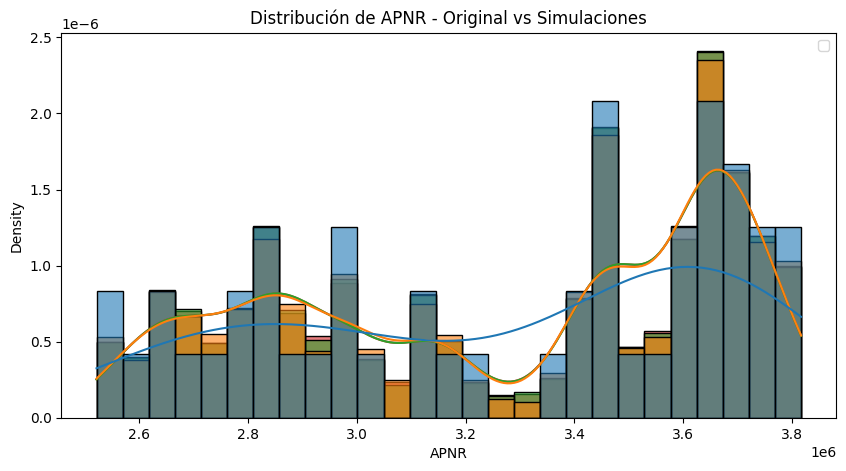

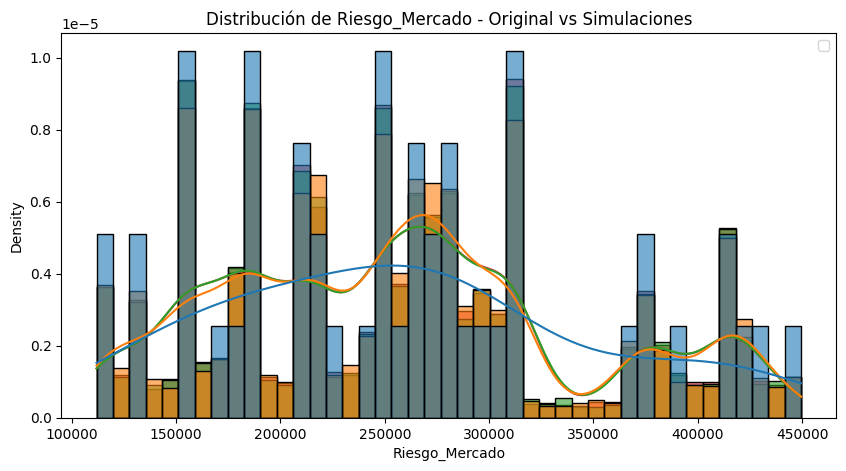

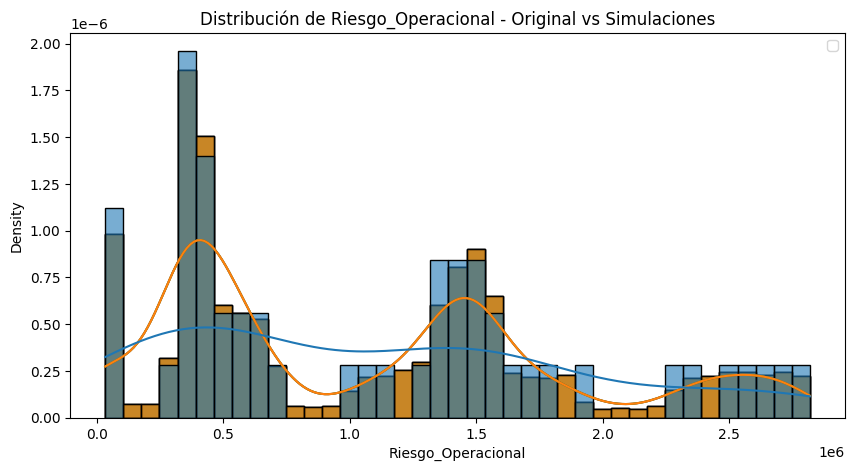

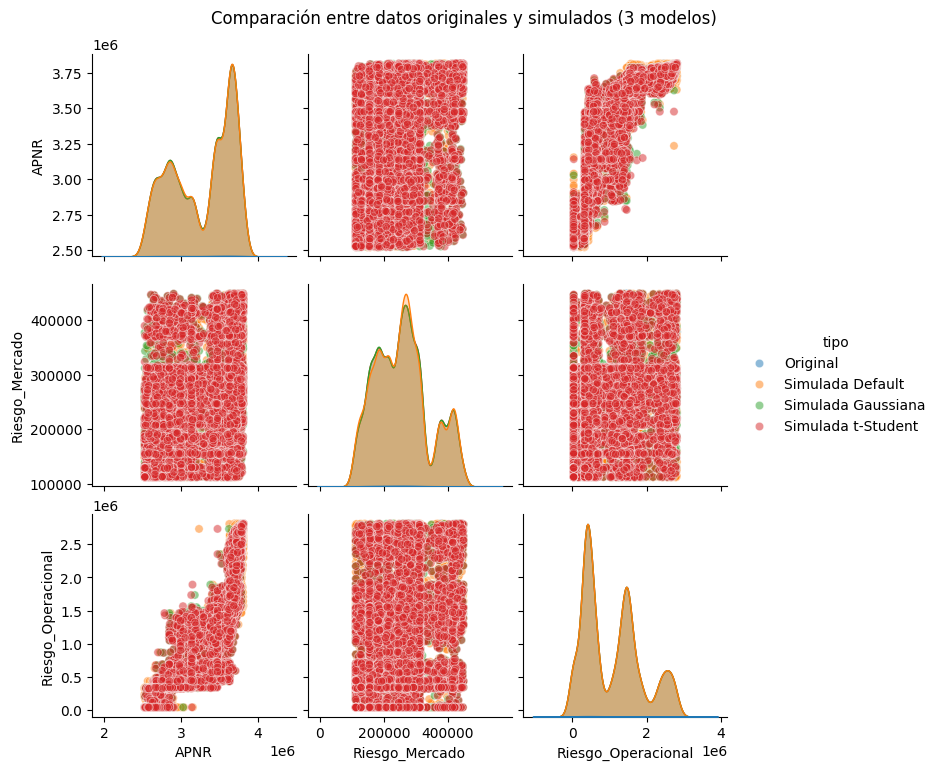

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear dataframes para cada simulación con columna tipo
df_sim_default = pd.DataFrame(sim_default, columns=df_variables.columns)
df_sim_default['tipo'] = 'Simulada Default'

df_sim_gauss = pd.DataFrame(sim_gauss, columns=df_variables.columns)
df_sim_gauss['tipo'] = 'Simulada Gaussiana'

df_sim_t = pd.DataFrame(sim_t, columns=df_variables.columns)
df_sim_t['tipo'] = 'Simulada t-Student'

# Datos originales con etiqueta
df_original = df_variables.copy()
df_original['tipo'] = 'Original'

# Concatenar todo para graficar
combined_df = pd.concat([df_original, df_sim_default, df_sim_gauss, df_sim_t], ignore_index=True)

# Histograma para cada variable y tipo
for col in df_variables.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=combined_df, x=col, hue='tipo', kde=True, stat='density', common_norm=False, alpha=0.6)
    plt.title(f'Distribución de {col} - Original vs Simulaciones')
    plt.legend()
    plt.show()

# Pairplot para comparar dependencias (puede tardar un poco)
sns.pairplot(combined_df, hue='tipo', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Comparación entre datos originales y simulados (3 modelos)', y=1.02)
plt.show()


In [56]:
# Imprimir la matriz que representa la estructura vine
print("Matriz de estructura R-vine:")
print(vine_default.structure.matrix)

# También puedes imprimir el orden de variables en el vine
print("Orden de variables en el vine:")
print(vine_default.structure.order)

Matriz de estructura R-vine:
[[1 3 3]
 [3 1 0]
 [2 0 0]]
Orden de variables en el vine:
[2, 1, 3]


In [57]:
def is_cvine(matrix):
    d = matrix.shape[0]
    # En C-vine, la primera fila (excepto la diagonal) tiene el mismo valor
    first_row = matrix[0, 1:]
    return np.all(first_row == first_row[0]) and first_row[0] != 0

# Ejemplo con tu matriz
mat = np.array([[1, 3, 3],
                [3, 1, 0],
                [2, 0, 0]])
print("¿Es C-vine?", is_cvine(mat))


¿Es C-vine? True


Comparaciòn de modelos

In [58]:
# Crear columna 'Total' en df_variables con la suma de las tres variables por fila
df_variables['Total'] = df_variables.sum(axis=1)

# Ahora 'Total' será el vector de suma original que usas para comparar
Total_original = df_variables['Total']

In [59]:
Total

array([6108762.14854799, 6720708.15412065, 5641726.83299764, ...,
       5341138.77993019, 4415432.69681873, 5653726.11566121],
      shape=(10000,))

Comparación de modelos - Estadísticas descriptivas y KS test

Datos originales - Media: 4625766.4040, Varianza: 1445346806202.1946

Distribución Directa:
  Media simulada: 4257195.0969
  Varianza simulada: 1113728664974.3806
  KS test estadístico: 0.2400, p-valor: 0.1124
  No se rechaza la hipótesis de igualdad de distribuciones

Simulación Multivariada:
  Media simulada: 4347901.8736
  Varianza simulada: 1672663423250.1953
  KS test estadístico: 0.1800, p-valor: 0.3959
  No se rechaza la hipótesis de igualdad de distribuciones

Simulación Gaussiana:
  Media simulada: 4735561.4086
  Varianza simulada: 1361858147143.3198
  KS test estadístico: 0.1000, p-valor: 0.9667
  No se rechaza la hipótesis de igualdad de distribuciones

Simulación Vine:
  Media simulada: 4614439.1461
  Varianza simulada: 1372847364300.5996
  KS test estadístico: 0.1000, p-valor: 0.9667
  No se rechaza la hipótesis de igualdad de distribuciones

Simulación t:
  Media simulada: 4615979.3056
  Varianza simulada: 1341

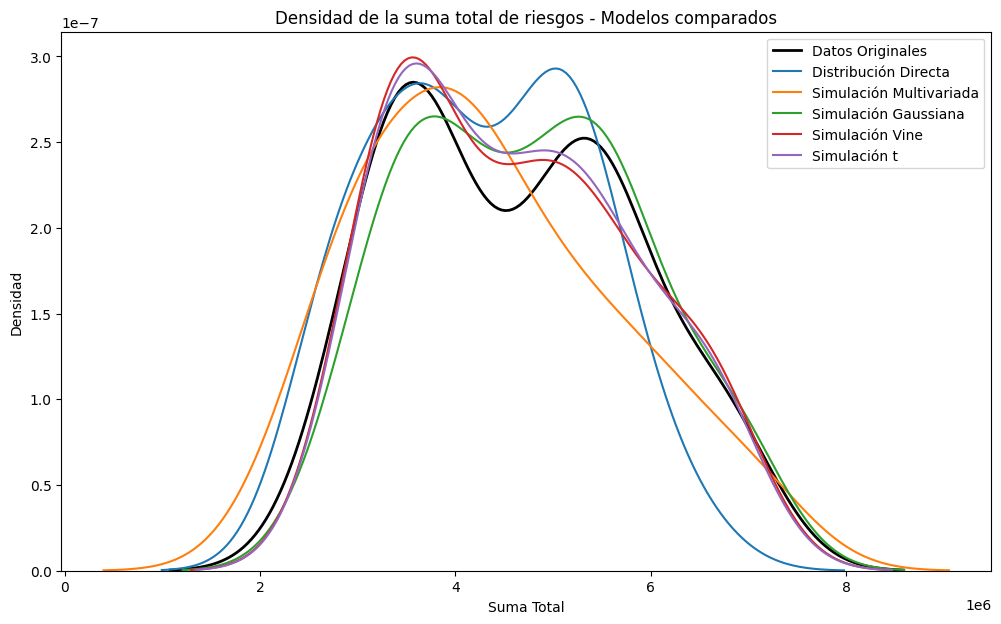

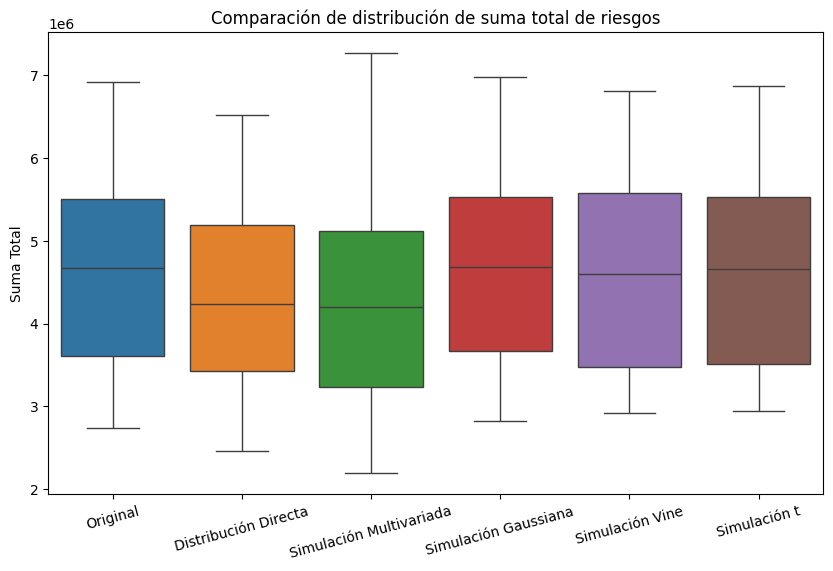

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

def evaluate_risk_models(original_sum, sum_sim_dist, sum_sim_mv, sum_sim_gauss, sum_sim_vine,sum_sim_t):
    # Convertir todo a arrays numpy por si acaso
    original_sum = np.asarray(original_sum)
    sum_sim_dist = np.asarray(sum_sim_dist)
    sum_sim_mv = np.asarray(sum_sim_mv)
    sum_sim_gauss = np.asarray(sum_sim_gauss)
    sum_sim_vine = np.asarray(sum_sim_vine)
    sum_sim_t = np.asarray(sum_sim_t)
    
    # Diccionario para iterar
    models = {
        'Distribución Directa': sum_sim_dist,
        'Simulación Multivariada': sum_sim_mv,
        'Simulación Gaussiana': sum_sim_gauss,
        'Simulación Vine': sum_sim_vine,
        'Simulación t': sum_sim_t
    }
    
    # Estadísticas descriptivas y KS test
    print("Comparación de modelos - Estadísticas descriptivas y KS test\n")
    print(f"Datos originales - Media: {np.mean(original_sum):.4f}, Varianza: {np.var(original_sum):.4f}\n")
    
    for name, data in models.items():
        mean = np.mean(data)
        var = np.var(data)
        ks_stat, ks_pvalue = ks_2samp(original_sum, data)
        print(f"{name}:")
        print(f"  Media simulada: {mean:.4f}")
        print(f"  Varianza simulada: {var:.4f}")
        print(f"  KS test estadístico: {ks_stat:.4f}, p-valor: {ks_pvalue:.4f}")
        print(f"  {'No se rechaza' if ks_pvalue > 0.05 else 'Se rechaza'} la hipótesis de igualdad de distribuciones\n")
    
    # Gráficos de densidad superpuestos
    plt.figure(figsize=(12, 7))
    sns.kdeplot(original_sum, label='Datos Originales', color='black', linewidth=2)
    for name, data in models.items():
        sns.kdeplot(data, label=name)
    plt.title('Densidad de la suma total de riesgos - Modelos comparados')
    plt.xlabel('Suma Total')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()
    
    # Boxplot para comparar distribuciones
    plt.figure(figsize=(10, 6))
    df_box = pd.DataFrame({
        'Original': original_sum,
        'Distribución Directa': sum_sim_dist,
        'Simulación Multivariada': sum_sim_mv,
        'Simulación Gaussiana': sum_sim_gauss,
        'Simulación Vine': sum_sim_vine,
        'Simulación t': sum_sim_t
    })
    sns.boxplot(data=df_box)
    plt.title('Comparación de distribución de suma total de riesgos')
    plt.ylabel('Suma Total')
    plt.xticks(rotation=15)
    plt.show()

# Ejecutar evaluación
n_orig = len(Total_original)

evaluate_risk_models(
    original_sum=Total_original,
    sum_sim_dist=pd.Series(Total).sample(n=n_orig, random_state=42, replace=True).values,
    sum_sim_mv=simulacion_MV['Total'].sample(n=n_orig, random_state=42, replace=True).values,
    sum_sim_gauss=pd.Series(sum_gauss).sample(n=n_orig, random_state=42, replace=True).values,
    sum_sim_vine=pd.Series(sum_default).sample(n=n_orig, random_state=42, replace=True).values,
    sum_sim_t=pd.Series(sum_t).sample(n=n_orig, random_state=42, replace=True).values,
    )

Evaluación avanzada de modelos:

Distribución Directa:
  Anderson-Darling statistic: 1.2881
  p-valor AD test: 0.0957
  Wasserstein distance: 369260.6468
  No se rechaza la hipótesis de igualdad de distribuciones



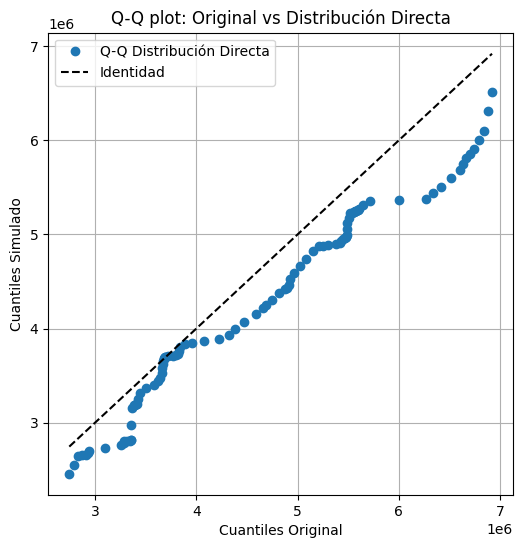

Simulación Multivariada:
  Anderson-Darling statistic: 0.4141
  p-valor AD test: 0.2249
  Wasserstein distance: 338115.7426
  No se rechaza la hipótesis de igualdad de distribuciones



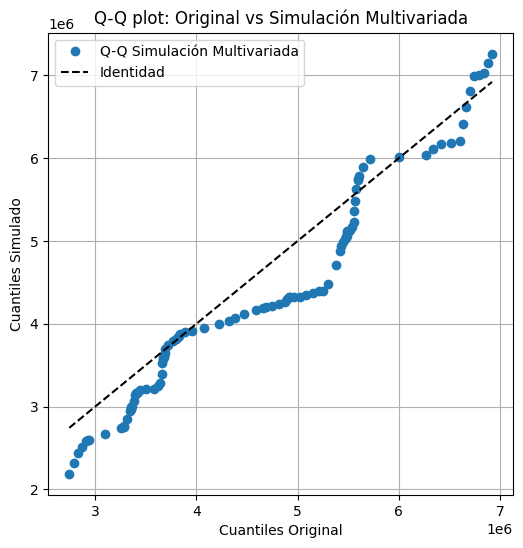

Simulación Gaussiana:
  Anderson-Darling statistic: -1.0000
  p-valor AD test: 0.2500
  Wasserstein distance: 130353.3989
  No se rechaza la hipótesis de igualdad de distribuciones



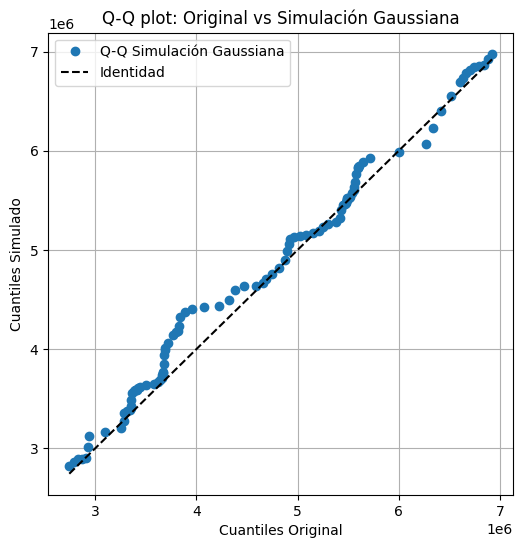

Simulación Vine:
  Anderson-Darling statistic: -0.9355
  p-valor AD test: 0.2500
  Wasserstein distance: 116442.2582
  No se rechaza la hipótesis de igualdad de distribuciones



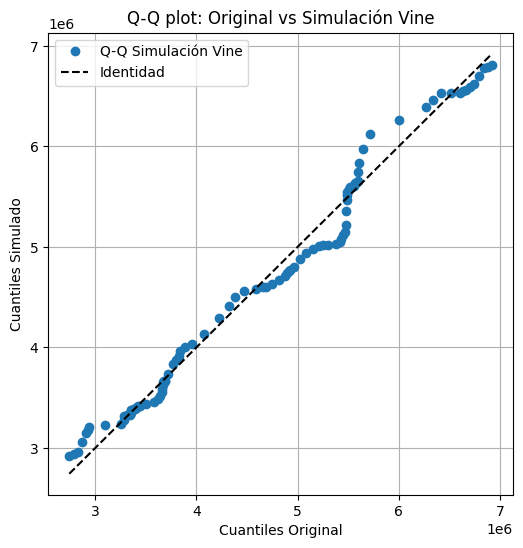

Simulación t:
  Anderson-Darling statistic: -0.9384
  p-valor AD test: 0.2500
  Wasserstein distance: 111732.5172
  No se rechaza la hipótesis de igualdad de distribuciones



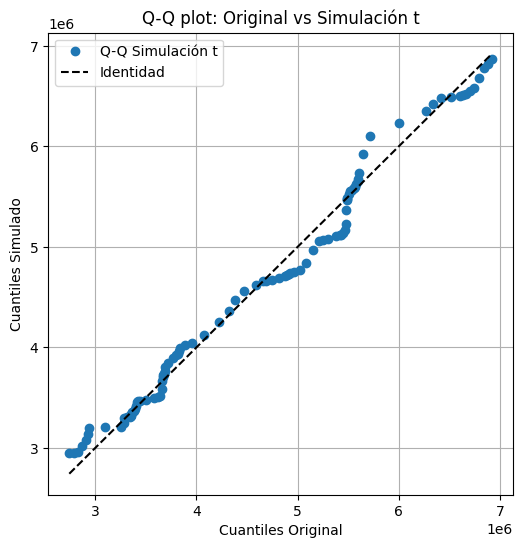

In [61]:
from scipy.stats import anderson_ksamp, wasserstein_distance
import matplotlib.pyplot as plt
import numpy as np

def advanced_model_evaluation(original_sum, model_sums):
    """
    original_sum: array o lista con la suma original
    model_sums: dict con nombre_modelo: array_suma_simulada
    """
    print("Evaluación avanzada de modelos:\n")
    
    for name, sim_sum in model_sums.items():
        # Anderson-Darling test
        ad_result = anderson_ksamp([original_sum, sim_sum])
        
        # Wasserstein distance
        wd = wasserstein_distance(original_sum, sim_sum)
        
        print(f"{name}:")
        print(f"  Anderson-Darling statistic: {ad_result.statistic:.4f}")
        print(f"  p-valor AD test: {ad_result.significance_level:.4f}")
        print(f"  Wasserstein distance: {wd:.4f}")
        print(f"  {'No se rechaza' if ad_result.significance_level > 0.05 else 'Se rechaza'} la hipótesis de igualdad de distribuciones\n")
        
        # Q-Q plot
        plt.figure(figsize=(6, 6))
        quantiles = np.linspace(0, 1, 100)
        q_orig = np.quantile(original_sum, quantiles)
        q_sim = np.quantile(sim_sum, quantiles)
        plt.plot(q_orig, q_sim, marker='o', linestyle='', label=f'Q-Q {name}')
        plt.plot([q_orig.min(), q_orig.max()], [q_orig.min(), q_orig.max()], 'k--', label='Identidad')
        plt.xlabel('Cuantiles Original')
        plt.ylabel('Cuantiles Simulado')
        plt.title(f'Q-Q plot: Original vs {name}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Ejemplo de uso con tus datos (ya con tamaños iguales o muestreados):
# Muestreo con reemplazo para igualar tamaño
Total_sampled = pd.Series(Total).sample(n=n_orig, random_state=42, replace=True).values
simulacion_MV_sampled = simulacion_MV['Total'].sample(n=n_orig, random_state=42, replace=True).values
sum_gauss_sampled = pd.Series(sum_gauss).sample(n=n_orig, random_state=42, replace=True).values
sum_default_sampled = pd.Series(sum_default).sample(n=n_orig, random_state=42, replace=True).values
sum_t_sampled = pd.Series(sum_t).sample(n=n_orig, random_state=42, replace=True).values

# Diccionario para evaluación avanzada
model_sums = {
    'Distribución Directa': Total_sampled,
    'Simulación Multivariada': simulacion_MV_sampled,
    'Simulación Gaussiana': sum_gauss_sampled,
    'Simulación Vine': sum_default_sampled,
    'Simulación t': sum_t_sampled
}

# Evaluación adicional
advanced_model_evaluation(Total_original, model_sums)


In [ ]:
# --- Cálculo de estadísticos para cada cópula ---

def summary_stats(name, data):
    return {
        "Modelo": name,
        "Media": np.mean(data),
        "Desviación estándar": np.std(data),
        "Percentil 95": np.percentile(data, 95),
        "Percentil 99": np.percentile(data, 99),
        "Percentil 99.9": np.percentile(data, 99.9)
    }

# Usamos las sumas de pérdidas simuladas que ya calculaste
stats_results = []

stats_results.append(summary_stats("Cópula Gaussiana", sum_gauss))
stats_results.append(summary_stats("Cópula t-Student", sum_t))
stats_results.append(summary_stats("Cópula Vine (mixta)", sum_default))

# Convertir en DataFrame
df_stats = pd.DataFrame(stats_results)

                Modelo      Media  Desviación estándar  Percentil 95  \
0     Cópula Gaussiana 4605441.05           1164609.82    6635722.72   
1     Cópula t-Student 4618337.07           1161662.01    6651761.36   
2  Cópula Vine (mixta) 4618361.88           1168519.12    6671066.46   

   Percentil 99  Percentil 99.9  
0    6892930.06      7035366.67  
1    6878435.24      7004797.02  
2    6857990.45      6954533.08  


In [63]:
df_stats

,Modelo,Media,Desviación estándar,Percentil 95,Percentil 99,Percentil 99.9
0,Cópula Gaussiana,4605441.05,1164609.82,6635722.72,6892930.06,7035366.67
1,Cópula t-Student,4618337.07,1161662.01,6651761.36,6878435.24,7004797.02
2,Cópula Vine (mixta),4618361.88,1168519.12,6671066.46,6857990.45,6954533.08


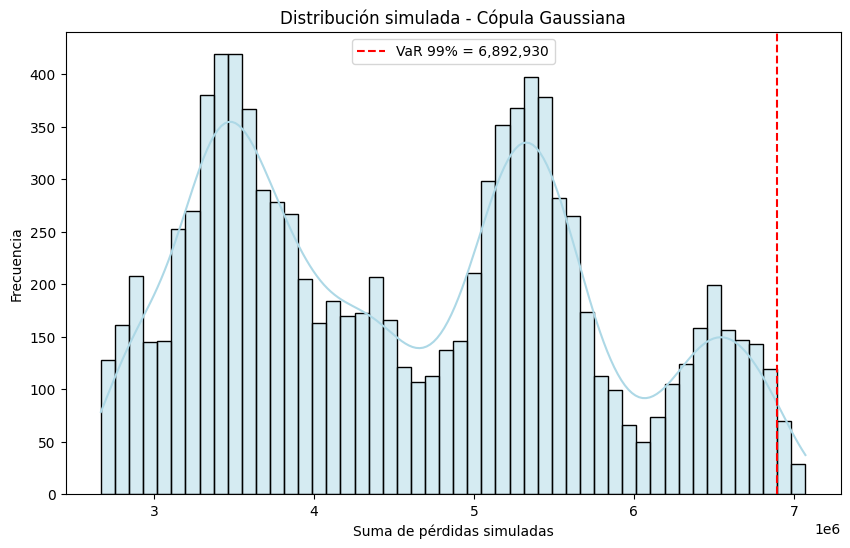

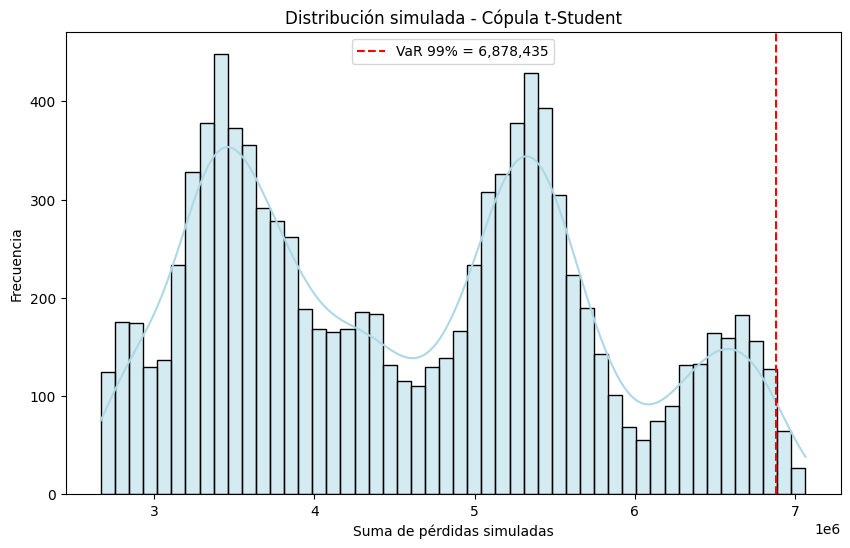

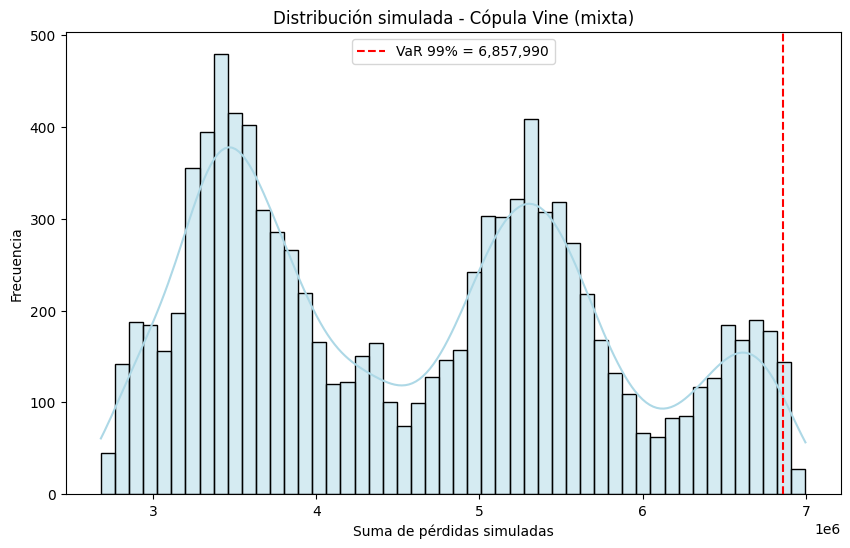

In [64]:
# --- Gráficas de las distribuciones con VaR 99% ---
copulas = {
    "Cópula Gaussiana": sum_gauss,
    "Cópula t-Student": sum_t,
    "Cópula Vine (mixta)": sum_default
}

for name, data in copulas.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=50, kde=True, color='lightblue')
    
    # Percentil 99
    p99 = np.percentile(data, 99)
    plt.axvline(p99, color='red', linestyle='--', label=f'VaR 99% = {p99:,.0f}')
    
    plt.title(f"Distribución simulada - {name}")
    plt.xlabel("Suma de pérdidas simuladas")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()